In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from shap import plots, Explanation
from sklearn.preprocessing import StandardScaler
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics.functional import binary_f1_score
import shap
from tqdm import tqdm
from matplotlib import ticker
import pickle

pd.set_option('display.max_columns', None)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device = 'cpu'

In [4]:
x_features = [    
    "flow_duration", "fwd_pkts_tot", "bwd_pkts_tot",
    "fwd_data_pkts_tot", "bwd_data_pkts_tot", "fwd_pkts_per_sec", "bwd_pkts_per_sec", "flow_pkts_per_sec",
    "down_up_ratio", "fwd_header_size_tot", "fwd_header_size_min", "fwd_header_size_max",
    "bwd_header_size_tot", "bwd_header_size_min", "bwd_header_size_max", "flow_FIN_flag_count",
    "flow_SYN_flag_count", "flow_RST_flag_count", "fwd_PSH_flag_count", "bwd_PSH_flag_count", "flow_ACK_flag_count",
    "fwd_URG_flag_count", "bwd_URG_flag_count", "flow_CWR_flag_count", "flow_ECE_flag_count",
    "fwd_pkts_payload.min", "fwd_pkts_payload.max", "fwd_pkts_payload.tot", "fwd_pkts_payload.avg",
    "fwd_pkts_payload.std", "bwd_pkts_payload.min", "bwd_pkts_payload.max", "bwd_pkts_payload.tot",
    "bwd_pkts_payload.avg", "bwd_pkts_payload.std", "flow_pkts_payload.min", "flow_pkts_payload.max",
    "flow_pkts_payload.tot", "flow_pkts_payload.avg", "flow_pkts_payload.std", "fwd_iat.min",
    "fwd_iat.max", "fwd_iat.tot", "fwd_iat.avg", "fwd_iat.std", "bwd_iat.min", "bwd_iat.max",
    "bwd_iat.tot", "bwd_iat.avg", "bwd_iat.std", "flow_iat.min", "flow_iat.max", "flow_iat.tot",
    "flow_iat.avg", "flow_iat.std", "payload_bytes_per_second", "fwd_subflow_pkts", "bwd_subflow_pkts",
    "fwd_subflow_bytes", "bwd_subflow_bytes", "fwd_bulk_bytes", "bwd_bulk_bytes", "fwd_bulk_packets",
    "bwd_bulk_packets", "fwd_bulk_rate", "bwd_bulk_rate", "active.min", "active.max", "active.tot",
    "active.avg", "active.std", "idle.min", "idle.max", "idle.tot", "idle.avg", "idle.std",
    "fwd_init_window_size", "bwd_init_window_size", "fwd_last_window_size"
]

In [5]:
def stratified_under_sample(group: pd.DataFrame, k: int, random_state: int):
    global category_size
    # shuffle data
    group = group.sample(frac=1, random_state=random_state)
    
    # making a dictionary for checking if all the groups are equally insert into the array
    unique_categories = set(group)
    
    # getting the size of each category per fold
    folded_category = category_size // k
    
    # storing temporary data
    test_res = []
    train_res = []

    for i in range(k):
        test_indexes = []
        train_indexes = []
        
        # for each iteration of the outer loop we need to reset dict
        count_type = {category: 0 for category in unique_categories}
        
        for category in unique_categories:
            # making a window of data to retreive
            if (category == 'Background') | (category == 'Benign'):
                start = (folded_category * 2) * i
                stop = (folded_category * 2) * (i + 1)
            else:
                start = folded_category * i
                stop = folded_category * (i + 1)
            test_indexes.extend(group[group == category].iloc[start:stop].index)
        
        for x in group.index:
            if x not in test_indexes:
                train_indexes.append(x)
                
        # shuffling the data with the same seed in order to have the same result in both the dataset
        np.random.shuffle(test_indexes)
        test_res.append(test_indexes)
        np.random.shuffle(train_indexes)
        train_res.append(train_indexes)
        
    return test_res, train_res

In [6]:
# how need to initialize a nn.relu each time you use it
class MLP(nn.Module):
    def __init__(self, n_features):
        super(MLP, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(n_features, 6), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(6, 3), nn.ReLU())
        self.fc3 = nn.Sequential(nn.Linear(3, 1), nn.Sigmoid())

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [7]:
def mlp_train(X_train, y_train, verbose, epochs):
    # Initialize the model
    model = MLP(X_train.shape[1]).to(device)

    # Define the loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    if type(X_train) == pd.core.frame.DataFrame:
        X_train = X_train.to_numpy()
    
    # Convert data to PyTorch tensors (assuming X_train and y_train are numpy arrays)
    X_train_tensor = torch.from_numpy(X_train.astype(np.float32)).to(device)
    y_train_tensor = torch.from_numpy(y_train.to_numpy()).to(device)

    # Train the model
    epochs = epochs
    batch_size = 200
    
    start_train = time.time()
    for epoch in range(epochs):
        for i in range(0, len(X_train_tensor), batch_size):
            inputs = X_train_tensor[i:i+batch_size]
            labels = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

        # Optionally, print the loss at each epoch
        if verbose:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}")

    end_train = time.time()
    print("execution time: ", end_train - start_train)
        
    return model

In [8]:
def cross_validation(X, y, group, verbose, epochs):
    test_kfold, train_kfold = stratified_under_sample(group, 10, 12)
    '''
    if type(X) == pd.core.frame.DataFrame:
        X = X.to_numpy()
    '''
    cvscores = []

    start_cv = time.time()
    for test, train in zip(test_kfold, train_kfold):
        X_train = scaler.transform(X.loc[train])
        X_test = scaler.transform(X.loc[test])
        
        # rimuovere validation a ogni turno
        model = mlp_train(X_train, y[train], False, epochs)
        
        with torch.no_grad():
            model.eval()
            X_test_tensor = torch.from_numpy(X_test.astype(np.float32)).to(device)
            y_predicted = (model(X_test_tensor) >= 0.5).squeeze().cpu()
            
            cvscores.append(metrics.f1_score(y[test], y_predicted))
    end_cv = time.time()    
    
    return np.mean(cvscores), np.std(cvscores), end_cv - start_cv

In [9]:
with open('mlp_data/ds.pickle', 'rb') as handle:
    ds = pickle.load(handle)

with open('mlp_data/model.pickle', 'rb') as handle:
    model = pickle.load(handle)
    
with open('mlp_data/kernel_exp.pickle', 'rb') as handle:
    exp = pickle.load(handle)

In [10]:
category_size = 3279
sampling_weights = {'Background': category_size * 2, 'Benign': category_size * 2, 'XMRIGCC CryptoMiner': category_size, 'Probing': category_size, 'Bruteforce': category_size, 'Bruteforce-XML': category_size}

rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_weights)
X_res, y_res = rus.fit_resample(ds[x_features], ds.traffic_category)

In [11]:
scaler = StandardScaler()
scaler.fit(ds[x_features])

StandardScaler()

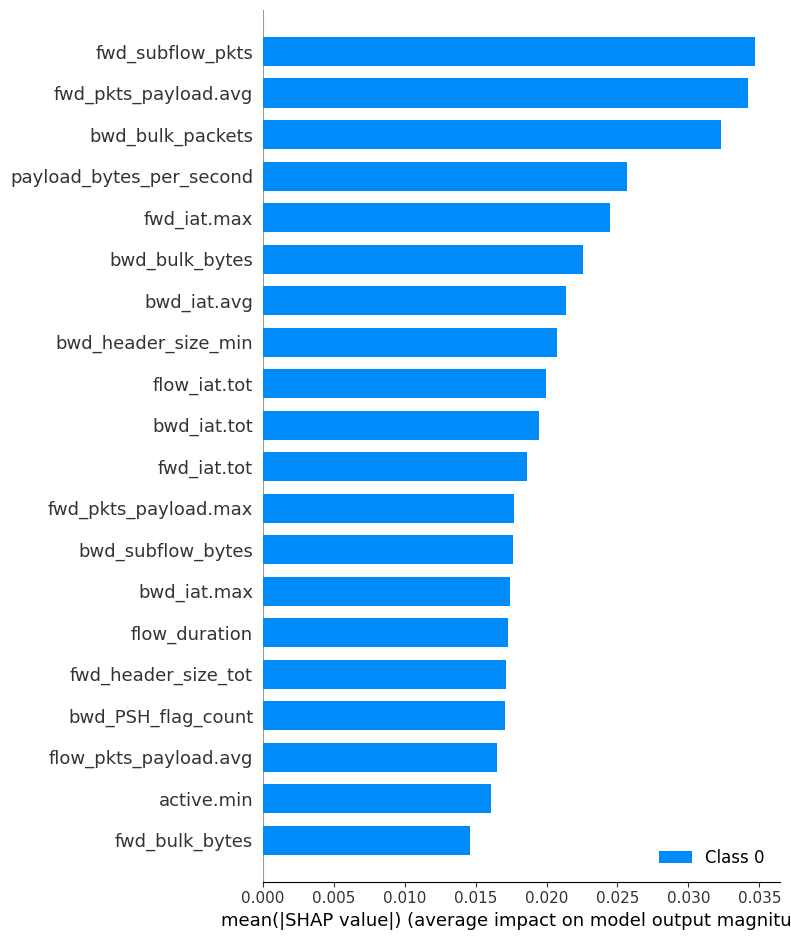

In [12]:
shap.summary_plot(exp, max_display=20)

In [14]:
feature_importance = pd.DataFrame(data={'importance' : exp[0].abs.mean(0).values, 'feature': x_features})
feature_importance.sort_values('importance',ascending=False).head(20)

,importance,feature
56,0.034727,fwd_subflow_pkts
28,0.034205,fwd_pkts_payload.avg
63,0.032280,bwd_bulk_packets
55,0.025664,payload_bytes_per_second
41,0.024461,fwd_iat.max
61,0.022606,bwd_bulk_bytes
48,0.021343,bwd_iat.avg
13,0.020709,bwd_header_size_min
52,0.019980,flow_iat.tot
47,0.019465,bwd_iat.tot


In [15]:
feature_above_zero = feature_importance.query('importance > 0').sort_values('importance',ascending=False)['feature'].to_list()

In [27]:
%%time

# since I'm using only two tree it make sense to split the job on multiple cores
# so each forest will take two cores since it have two tree on it and then I will run along side other 6 forest in order to use all the cores
def get_score(features):
    X = X_res[features]
    y = ds.loc[y_res.index].Label
    cv_mean, cv_std, cv_time = cross_validation(X, y, y_res, 0, 131)
    return cv_mean, cv_std, len(features), cv_time

def recursive_reduction():
    scores = []
    score_std = []
    n_features = []
    cv_time = []

    global scaler
    scaler.fit(ds[['fwd_iat.tot']])

    # making a warm up run otherwise the first one will be always slower than the others
    # only one features so that it can be as fast as possibile
    get_score(['fwd_iat.tot'])

    scaler.fit(ds[feature_above_zero])
    result = get_score(feature_above_zero)
    scores.append(result[0])
    score_std.append(result[1])
    n_features.append(result[2])    
    cv_time.append(result[3])
    
    for i in range(1,len(feature_above_zero)):
        print(f"testing with {len(feature_above_zero[:-i])} features")
        scaler.fit(ds[feature_above_zero[:-i]])
        result = get_score(feature_above_zero[:-i])
        scores.append(result[0])
        score_std.append(result[1])
        n_features.append(result[2])
        cv_time.append(result[3])
        
    return scores, score_std, n_features, cv_time

result = recursive_reduction()
feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2], 'cv_time': result[3]})

execution time:  14.186438798904419
execution time:  14.518194675445557
execution time:  14.938334941864014
execution time:  14.84190559387207
execution time:  14.989662408828735
execution time:  15.209470510482788
execution time:  17.64571762084961
execution time:  17.376767873764038
execution time:  15.377801656723022
execution time:  15.997284412384033
execution time:  15.48797059059143
execution time:  16.379051208496094
execution time:  18.161205053329468
execution time:  17.994620323181152
execution time:  17.35856032371521
execution time:  15.540313720703125
execution time:  15.414971828460693
execution time:  17.05682110786438
execution time:  17.46344256401062
execution time:  18.753684759140015
testing with 2 features
execution time:  16.03272032737732
execution time:  16.320013761520386
execution time:  14.45509386062622
execution time:  14.418349266052246
execution time:  14.161381959915161
execution time:  14.278037786483765
execution time:  14.353712320327759
execution ti

In [17]:
load = True

if load:
    with open('mlp_data/feature_reduction_scores_kernel.pickle', 'rb') as handle:
        feature_reduction_scores = pickle.load(handle)
else:
    with open('mlp_data/feature_reduction_scores_kernel.pickle', 'wb') as handle:
        pickle.dump(feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

<Axes: xlabel='n_features', ylabel='cv_time'>

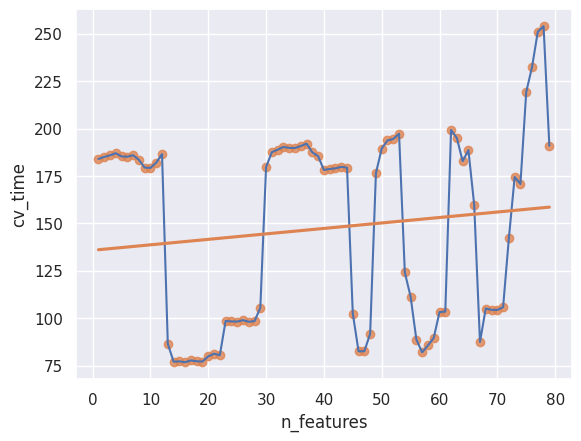

In [18]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="cv_time")
sns.regplot(data=feature_reduction_scores, x="n_features", y="cv_time", ci=None)  # ci=None removes confidence intervals

<Axes: xlabel='n_features', ylabel='F1_score'>

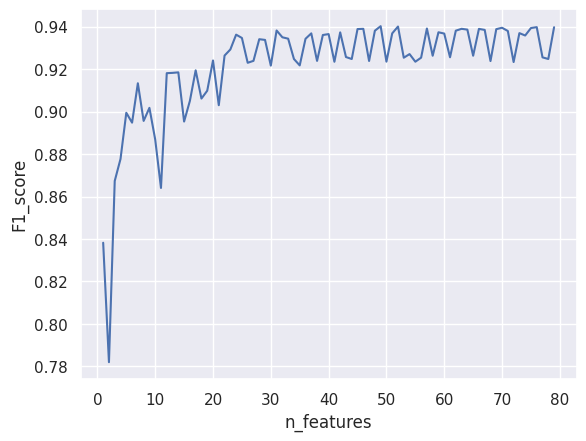

In [19]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="F1_score")

<Axes: xlabel='n_features', ylabel='score_std'>

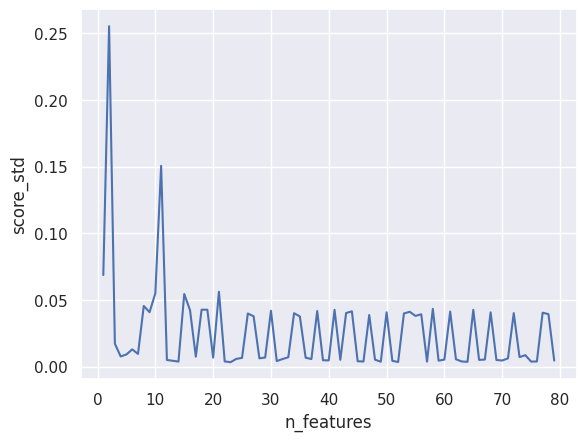

In [20]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="score_std")

In [21]:
feature_reduction_scores.sort_values('F1_score', ascending=False)

,F1_score,score_std,n_features,cv_time
30,0.940220,0.003627,49,176.463298
27,0.940048,0.003414,52,194.485320
3,0.939771,0.003815,76,232.294896
0,0.939728,0.004467,79,190.907334
9,0.939476,0.004542,70,104.375099
...,...,...,...,...
75,0.877686,0.007598,4,186.967900
76,0.867344,0.017132,3,185.881265
68,0.864035,0.150539,11,182.035389
78,0.838227,0.068636,1,183.933044


In [22]:
# add also training time
attack_f1 = []
attack_recall = []
attack_precision = []
cv_score_avg = []
cv_score_std = []
n_features = []
attacks = []
fit_time = []
pred_time = []

# warmup boolean, this variable will be used to load in memory the function in order to have reliable time measures
warmup = True


def test_zero_day(attack, features, rus, rus_attack):
    print(f"training with {len(features)} features")
    global warmup
    epochs = 99
    
    X_res, y_res = rus.fit_resample(ds[features], ds.traffic_category)
    
    X_attack, y_attack = rus_attack.fit_resample(ds[features], ds.traffic_category)
    X_attack = torch.from_numpy(X_attack.to_numpy().astype(np.float32)).to(device)
    y_attack = ds.loc[y_attack.index].Label
    
    cv_mean, cv_std, cv_time = cross_validation(X_res, ds.loc[y_res.index].Label, y_res, 0, epochs)
    
    if warmup:
        mlp = mlp_train(X_res, ds.loc[y_res.index].Label, False, epochs)
        with torch.no_grad():
            mlp.eval()
            mlp(X_attack)
    
    start_fit = time.time()
    mlp = mlp_train(X_res, ds.loc[y_res.index].Label, False, epochs)
    end_fit = time.time()
    
    with torch.no_grad():
        start_pred = time.time()
        mlp.eval()
        y_predicted = mlp(X_attack)
        end_pred = time.time()
        y_predicted = (y_predicted >= 0.5).squeeze().cpu()
    
    attack_f1.append(metrics.f1_score(y_attack, y_predicted))
    attack_recall.append(metrics.recall_score(y_attack, y_predicted))
    attack_precision.append(metrics.precision_score(y_attack, y_predicted))
    cv_score_avg.append(cv_mean)
    cv_score_std.append(cv_std)
    n_features.append(len(features))
    attacks.append(attack)
    fit_time.append(end_fit - start_fit)
    pred_time.append(end_pred - start_pred)

    # at the very first iteration we change it to false
    warmup = False
    
def recursive_reduction(attack):
    global scaler
    # making a sample for having a 1:1 ration for positive and negative class
    # keep in mind that in the training I will have only three attacks, while for the test only one attack
    sampling_weights = {'Background': 4918, 'Benign': 4918, 'XMRIGCC CryptoMiner': 3279, 'Probing': 3279, 'Bruteforce': 3279, 'Bruteforce-XML': 3279}
    sampling_attack = {'Background': 1638, 'Benign': 1638, 'XMRIGCC CryptoMiner': 0, 'Probing': 0, 'Bruteforce': 0, 'Bruteforce-XML': 0}
    
    # removing all the attack observations
    sampling_weights[attack] = 0
    
    # doing the undersampling
    rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_weights)
    
    # adding the attack to the test dataset with the non attack traffic
    sampling_attack[attack] = 3279
    
    # making the dataset with only one attack
    rus_attack = RandomUnderSampler(random_state=42, sampling_strategy=sampling_attack)
    
    scaler.fit(ds[feature_above_zero])
    test_zero_day(attack, feature_above_zero, rus, rus_attack)

    for i in range(1,len(feature_above_zero)):
        scaler.fit(ds[feature_above_zero[:-i]])
        test_zero_day(attack, feature_above_zero[:-i], rus, rus_attack)

for attack in ['XMRIGCC CryptoMiner','Probing','Bruteforce','Bruteforce-XML']:
    print('traing for ', attack)
    %time recursive_reduction(attack)
    
zero_day_feature_reduction_scores = pd.DataFrame({'attack_f1': attack_f1,  'attack_recall': attack_recall, 'attack_precision': attack_precision, 'cv_score_avg': cv_score_avg, 'cv_score_std': cv_score_std, 'n_features': n_features, 'attack_name': attacks, 'fit_time': fit_time, 'pred_time': pred_time})

traing for  XMRIGCC CryptoMiner
training with 79 features
execution time:  5.674453496932983
execution time:  14.175336122512817
execution time:  14.681508779525757
execution time:  14.58438229560852
execution time:  8.13614559173584
execution time:  7.986181735992432
execution time:  8.069938659667969
execution time:  8.289740324020386
execution time:  9.137169599533081
execution time:  8.605452060699463
execution time:  9.255136966705322
execution time:  8.943970203399658
training with 78 features
execution time:  7.6902101039886475
execution time:  8.087034225463867
execution time:  7.865734577178955
execution time:  10.52326250076294
execution time:  8.027709722518921
execution time:  8.261245012283325
execution time:  7.994387149810791
execution time:  8.528512001037598
execution time:  8.562087535858154
execution time:  8.751326084136963
execution time:  9.214056968688965
training with 77 features
execution time:  7.8670995235443115
execution time:  8.11824655532837
execution tim

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 76 features
execution time:  8.427656650543213
execution time:  8.325188875198364
execution time:  8.10513949394226
execution time:  12.515936613082886
execution time:  11.676308870315552
execution time:  10.593810081481934
execution time:  8.216581583023071
execution time:  8.41988492012024
execution time:  8.867332458496094
execution time:  8.777086734771729
execution time:  9.441608667373657


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 75 features
execution time:  8.553956031799316
execution time:  8.825546741485596
execution time:  8.898615598678589
execution time:  8.919610500335693
execution time:  9.29435658454895
execution time:  9.055564641952515
execution time:  11.593392848968506
execution time:  15.535780191421509
execution time:  16.223652601242065
execution time:  15.59782338142395
execution time:  9.20420527458191


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 74 features
execution time:  9.39564561843872
execution time:  8.189977169036865
execution time:  8.212539434432983
execution time:  8.036948204040527
execution time:  8.231058597564697
execution time:  8.699131488800049
execution time:  8.709535121917725
execution time:  8.482892513275146
execution time:  8.54203724861145
execution time:  9.14614486694336
execution time:  12.221627950668335


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 73 features
execution time:  8.7078115940094
execution time:  8.19860553741455
execution time:  8.064560413360596
execution time:  8.986738681793213
execution time:  13.993149757385254
execution time:  14.69198989868164
execution time:  14.690376281738281
execution time:  15.298221826553345
execution time:  15.41226077079773
execution time:  14.656867027282715
execution time:  9.575906038284302
training with 72 features
execution time:  8.023455619812012
execution time:  8.202487230300903
execution time:  10.436800956726074
execution time:  8.125796556472778
execution time:  8.040509700775146
execution time:  11.119558811187744
execution time:  9.866648197174072
execution time:  14.787280082702637
execution time:  14.911287069320679
execution time:  15.611061334609985
execution time:  12.072529792785645
training with 71 features
execution time:  6.336186647415161
execution time:  5.990308046340942
execution time:  5.547909736633301
execution time:  5.619999170303345
execu

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 70 features
execution time:  4.651165962219238
execution time:  4.775414228439331
execution time:  4.8061957359313965
execution time:  5.096112012863159
execution time:  4.791080951690674
execution time:  4.787735939025879
execution time:  4.907614469528198
execution time:  4.996220111846924
execution time:  5.342490196228027
execution time:  5.269593715667725
execution time:  5.556561708450317
training with 69 features
execution time:  4.804433822631836
execution time:  4.810222387313843
execution time:  4.861630916595459
execution time:  4.795283555984497
execution time:  4.989820718765259
execution time:  4.799759387969971
execution time:  4.798058986663818
execution time:  5.198735475540161
execution time:  5.0869317054748535
execution time:  5.139837980270386
execution time:  5.559988498687744
training with 68 features
execution time:  4.729649066925049
execution time:  4.953830003738403
execution time:  4.843451499938965
execution time:  4.768853664398193
execution 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 67 features
execution time:  10.256916522979736
execution time:  10.54298996925354
execution time:  10.52162480354309
execution time:  10.387571811676025
execution time:  10.639986753463745
execution time:  4.882819175720215
execution time:  4.952058792114258
execution time:  5.068024396896362
execution time:  5.2118847370147705
execution time:  5.2006940841674805
execution time:  5.46256160736084
training with 66 features
execution time:  4.74975848197937
execution time:  4.8473851680755615
execution time:  4.8713319301605225
execution time:  4.962932586669922
execution time:  5.31015682220459
execution time:  4.791398048400879
execution time:  4.846064567565918
execution time:  5.160694360733032
execution time:  5.165280818939209
execution time:  5.2363121509552
execution time:  5.615652799606323
training with 65 features
execution time:  4.698767185211182
execution time:  4.821608781814575
execution time:  4.810467958450317
execution time:  4.817467212677002
execution 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 63 features
execution time:  5.6946117877960205
execution time:  5.851851463317871
execution time:  6.07480525970459
execution time:  6.204371690750122
execution time:  6.0389487743377686
execution time:  5.903381109237671
execution time:  5.746129274368286
execution time:  6.248311758041382
execution time:  6.246656656265259
execution time:  6.14141058921814
execution time:  6.576265335083008
training with 62 features
execution time:  5.620864391326904
execution time:  5.88234543800354
execution time:  5.761647701263428
execution time:  5.724403142929077
execution time:  5.792135000228882
execution time:  5.71438193321228
execution time:  5.802748441696167
execution time:  6.087016582489014
execution time:  6.17539119720459
execution time:  6.240415573120117
execution time:  6.507426977157593


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 61 features
execution time:  5.713197946548462
execution time:  5.710729598999023
execution time:  5.707789421081543
execution time:  5.792033672332764
execution time:  5.671901226043701
execution time:  5.73199725151062
execution time:  5.747864484786987
execution time:  5.942859888076782
execution time:  6.249942064285278
execution time:  6.115339756011963
execution time:  6.475187540054321


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 60 features
execution time:  5.603760242462158
execution time:  5.688545227050781
execution time:  5.841637849807739
execution time:  5.673385858535767
execution time:  5.768338918685913
execution time:  5.756108283996582
execution time:  5.724963426589966
execution time:  6.031843185424805
execution time:  6.141191005706787
execution time:  6.140912055969238
execution time:  6.275388479232788


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 59 features
execution time:  4.594501495361328
execution time:  5.014620780944824
execution time:  4.758110761642456
execution time:  4.796964406967163
execution time:  4.832036972045898
execution time:  4.759378671646118
execution time:  4.970402479171753
execution time:  5.052656173706055
execution time:  5.255510091781616
execution time:  5.156425714492798
execution time:  5.463034391403198


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 58 features
execution time:  4.650334596633911
execution time:  4.753396511077881
execution time:  4.875884771347046
execution time:  4.778623342514038
execution time:  4.754794120788574
execution time:  4.784959316253662
execution time:  4.863780736923218
execution time:  10.680196285247803
execution time:  5.355215549468994
execution time:  5.123811960220337
execution time:  5.56698751449585
training with 57 features
execution time:  4.606051445007324
execution time:  4.807848215103149
execution time:  4.891863822937012
execution time:  4.940842628479004
execution time:  4.758988857269287
execution time:  4.929622173309326
execution time:  4.819610595703125
execution time:  4.962425470352173
execution time:  5.221136569976807
execution time:  5.146141052246094
execution time:  5.49478554725647
training with 56 features
execution time:  4.757733106613159
execution time:  4.7888617515563965
execution time:  4.781134843826294
execution time:  4.909867763519287
execution ti

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 55 features
execution time:  4.585967540740967
execution time:  4.92702054977417
execution time:  7.183809518814087
execution time:  10.344683647155762
execution time:  10.249357461929321
execution time:  10.369176864624023
execution time:  10.489465475082397
execution time:  10.672559261322021
execution time:  11.720256567001343
execution time:  11.227232456207275
execution time:  12.079349756240845


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 54 features
execution time:  10.82949423789978
execution time:  10.799582958221436
execution time:  10.836556196212769
execution time:  10.884073734283447
execution time:  10.77972412109375
execution time:  10.94684100151062
execution time:  10.952453374862671
execution time:  11.264870166778564
execution time:  11.37952208518982
execution time:  11.769515991210938
execution time:  12.661745071411133
training with 53 features
execution time:  10.841968774795532
execution time:  10.866629123687744
execution time:  10.915936946868896
execution time:  10.926053524017334
execution time:  10.772853374481201
execution time:  10.902380466461182
execution time:  11.010268926620483
execution time:  11.33307695388794
execution time:  11.616069793701172
execution time:  11.777116060256958
execution time:  13.297327756881714


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 52 features
execution time:  10.83055067062378
execution time:  10.929133892059326
execution time:  10.757893323898315
execution time:  10.91288161277771
execution time:  10.895075559616089
execution time:  7.162452936172485
execution time:  5.6793532371521
execution time:  6.029419660568237
execution time:  6.078577280044556
execution time:  6.168936491012573
execution time:  6.472794532775879


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 51 features
execution time:  5.6591408252716064
execution time:  5.66643500328064
execution time:  5.6915059089660645
execution time:  5.734299182891846
execution time:  5.650543689727783
execution time:  5.666759490966797
execution time:  5.763378620147705
execution time:  5.890141248703003
execution time:  5.771546363830566
execution time:  5.865562677383423
execution time:  6.125688791275024


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 50 features
execution time:  4.678767204284668
execution time:  4.71630334854126
execution time:  4.716787576675415
execution time:  4.836182355880737
execution time:  4.840603828430176
execution time:  4.9749791622161865
execution time:  4.91436767578125
execution time:  4.983394622802734
execution time:  5.064603328704834
execution time:  5.128169059753418
execution time:  5.53277850151062


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 49 features
execution time:  4.647789478302002
execution time:  4.8819639682769775
execution time:  4.727755308151245
execution time:  4.714326858520508
execution time:  4.858210563659668
execution time:  4.756381273269653
execution time:  4.750966787338257
execution time:  5.1730406284332275
execution time:  5.436895847320557
execution time:  5.16911768913269
execution time:  5.6508402824401855


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 48 features
execution time:  4.595350742340088
execution time:  4.746871709823608
execution time:  4.927394390106201
execution time:  4.744572639465332
execution time:  4.746886491775513
execution time:  4.9045469760894775
execution time:  4.751905918121338
execution time:  4.930843114852905
execution time:  5.266418218612671
execution time:  5.127376317977905
execution time:  5.406256675720215
training with 47 features
execution time:  4.780274152755737
execution time:  10.324721336364746
execution time:  10.3873291015625
execution time:  10.412410974502563
execution time:  10.297740936279297
execution time:  10.455461263656616
execution time:  10.381890535354614
execution time:  10.652050256729126
execution time:  11.167393207550049
execution time:  11.17984414100647
execution time:  12.589934587478638


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 46 features
execution time:  10.15763783454895
execution time:  10.768150806427002
execution time:  10.884588479995728
execution time:  10.824162483215332
execution time:  10.732377529144287
execution time:  10.902285814285278
execution time:  10.87557601928711
execution time:  11.183454990386963
execution time:  11.693906307220459
execution time:  11.671051740646362
execution time:  12.652676105499268


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 45 features
execution time:  10.751614093780518
execution time:  10.75820803642273
execution time:  10.901865720748901
execution time:  10.907480001449585
execution time:  10.95932149887085
execution time:  10.992209672927856
execution time:  10.854139566421509
execution time:  11.325619220733643
execution time:  11.700411558151245
execution time:  11.771197319030762
execution time:  12.7159743309021


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 44 features
execution time:  10.481852293014526
execution time:  10.603522539138794
execution time:  10.8311607837677
execution time:  10.857978343963623
execution time:  10.750795602798462
execution time:  10.900656700134277
execution time:  10.873686075210571
execution time:  11.249302625656128
execution time:  11.724760055541992
execution time:  11.795218229293823
execution time:  12.70376181602478


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 43 features
execution time:  10.696890354156494
execution time:  10.711895227432251
execution time:  10.7184739112854
execution time:  10.876687049865723
execution time:  10.719409227371216
execution time:  10.424177408218384
execution time:  10.350250482559204
execution time:  10.642091512680054
execution time:  11.106935024261475
execution time:  11.156113624572754
execution time:  11.92634105682373
training with 42 features
execution time:  10.248124361038208
execution time:  10.361531019210815
execution time:  10.377685308456421
execution time:  10.244333744049072
execution time:  10.499427556991577
execution time:  10.378100633621216
execution time:  10.245901107788086
execution time:  10.746838808059692
execution time:  11.121022701263428
execution time:  10.977134227752686
execution time:  12.062601566314697
training with 41 features
execution time:  10.211065292358398
execution time:  10.359153509140015
execution time:  10.203580141067505
execution time:  10.33985

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 40 features
execution time:  10.144829750061035
execution time:  10.145326137542725
execution time:  6.137628555297852
execution time:  4.690108299255371
execution time:  4.741656541824341
execution time:  4.839753150939941
execution time:  4.732872724533081
execution time:  4.876130819320679
execution time:  5.209731340408325
execution time:  5.177087306976318
execution time:  5.418440580368042
training with 39 features
execution time:  4.582414388656616
execution time:  4.858200550079346
execution time:  6.839195013046265
execution time:  10.064911365509033
execution time:  10.192359447479248
execution time:  10.247089624404907
execution time:  10.176328897476196
execution time:  10.630982875823975
execution time:  10.826161861419678
execution time:  10.971030473709106
execution time:  11.795414447784424
training with 38 features
execution time:  10.038870573043823
execution time:  10.03334641456604
execution time:  10.195871114730835
execution time:  10.174848556518555

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  4.643904209136963
execution time:  4.757775068283081
execution time:  4.885254144668579
execution time:  4.662519931793213
execution time:  4.697866201400757
execution time:  4.891347885131836
execution time:  4.723519563674927
execution time:  4.873915910720825
execution time:  5.2048563957214355
execution time:  5.123019456863403
execution time:  5.399238348007202
training with 34 features
execution time:  5.644991636276245
execution time:  5.65444540977478
execution time:  5.752539157867432
execution time:  5.6313395500183105
execution time:  4.69585108757019
execution time:  4.706628084182739
execution time:  4.788322687149048
execution time:  4.8804402351379395
execution time:  5.061082601547241
execution time:  5.251051187515259
execution time:  5.422593355178833
training with 33 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  4.748637676239014
execution time:  4.715259790420532
execution time:  4.63406777381897
execution time:  4.655322551727295
execution time:  4.72341775894165
execution time:  4.629189729690552
execution time:  4.623076677322388
execution time:  5.17881178855896
execution time:  5.015799283981323
execution time:  4.937628507614136
execution time:  5.359280347824097
training with 32 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  4.594369411468506
execution time:  4.803269624710083
execution time:  4.678245782852173
execution time:  4.594027280807495
execution time:  4.596114158630371
execution time:  4.765920162200928
execution time:  4.613327980041504
execution time:  4.77870512008667
execution time:  5.0483245849609375
execution time:  5.015652656555176
execution time:  5.227385997772217
training with 31 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  4.766336679458618
execution time:  4.690906524658203
execution time:  4.595022678375244
execution time:  4.711640119552612
execution time:  5.5599365234375
execution time:  5.750547647476196
execution time:  5.72421669960022
execution time:  5.821328401565552
execution time:  6.011456489562988
execution time:  6.114262819290161
execution time:  6.319551706314087
training with 30 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  4.710812330245972
execution time:  4.764659643173218
execution time:  4.6189281940460205
execution time:  4.723036766052246
execution time:  4.600187063217163
execution time:  4.583466529846191
execution time:  4.662356376647949
execution time:  4.743973731994629
execution time:  4.9011430740356445
execution time:  4.9017863273620605
execution time:  5.37043571472168
training with 29 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  4.518362522125244
execution time:  4.727621555328369
execution time:  4.610750675201416
execution time:  4.617865800857544
execution time:  4.526962518692017
execution time:  4.607617616653442
execution time:  4.720030069351196
execution time:  4.7796525955200195
execution time:  4.987084150314331
execution time:  4.946872711181641
execution time:  5.174771785736084
training with 28 features
execution time:  5.498915433883667
execution time:  5.524345874786377
execution time:  5.645673513412476
execution time:  5.566384792327881
execution time:  5.558594703674316
execution time:  5.635708570480347
execution time:  5.523741245269775
execution time:  5.749905824661255
execution time:  6.0367865562438965
execution time:  5.937427759170532
execution time:  6.3254663944244385
training with 27 features
execution time:  5.466763019561768
execution time:  5.536726713180542
execution time:  5.6369640827178955
execution time:  5.569365739822388
execution time:  5.542197942733765

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.488464593887329
execution time:  5.670903205871582
execution time:  5.573228597640991
execution time:  6.040470838546753
execution time:  5.6529412269592285
execution time:  5.504683256149292
execution time:  5.5227673053741455
execution time:  5.826808929443359
execution time:  5.922082424163818
execution time:  5.965276002883911
execution time:  6.337262153625488
training with 25 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.476961851119995
execution time:  5.6314404010772705
execution time:  5.604061126708984
execution time:  5.626950740814209
execution time:  5.538650989532471
execution time:  5.536933183670044
execution time:  5.622832536697388
execution time:  5.7668609619140625
execution time:  5.96935248374939
execution time:  6.093017578125
execution time:  6.300329923629761
training with 24 features
execution time:  5.577652931213379
execution time:  5.585713148117065
execution time:  5.5471203327178955
execution time:  5.628452301025391
execution time:  5.5284364223480225
execution time:  5.554490089416504
execution time:  5.634003639221191
execution time:  5.749897480010986
execution time:  6.007791042327881
execution time:  5.956672430038452
execution time:  6.2700629234313965
training with 23 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.538229465484619
execution time:  5.578057765960693
execution time:  5.603309392929077
execution time:  5.5059661865234375
execution time:  5.494577407836914
execution time:  5.611985445022583
execution time:  5.507946014404297
execution time:  5.7191290855407715
execution time:  5.986830949783325
execution time:  5.899665117263794
execution time:  6.238845348358154
training with 22 features
execution time:  5.484017372131348
execution time:  5.528191566467285
execution time:  5.604813814163208
execution time:  5.479691028594971
execution time:  5.48005747795105
execution time:  5.580381870269775
execution time:  5.491626024246216
execution time:  5.702591180801392
execution time:  5.983702898025513
execution time:  5.9276041984558105
execution time:  6.363970041275024
training with 21 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.454485893249512
execution time:  5.582932949066162
execution time:  5.483974456787109
execution time:  5.499370336532593
execution time:  5.589032411575317
execution time:  5.484740972518921
execution time:  5.497087478637695
execution time:  5.804952144622803
execution time:  5.916647434234619
execution time:  5.903178691864014
execution time:  6.35129976272583
training with 20 features
execution time:  5.464849233627319
execution time:  5.6152894496917725
execution time:  5.5154712200164795
execution time:  5.493560791015625
execution time:  5.599462270736694
execution time:  5.509526968002319
execution time:  5.500963926315308
execution time:  5.8350207805633545
execution time:  5.918107986450195
execution time:  5.998477935791016
execution time:  6.223430633544922
training with 19 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.579086065292358
execution time:  5.526564836502075
execution time:  5.493992805480957
execution time:  5.600078821182251
execution time:  5.4938600063323975
execution time:  5.479469060897827
execution time:  5.741095066070557
execution time:  5.8026018142700195
execution time:  5.900930643081665
execution time:  6.008200645446777
execution time:  6.255680084228516
training with 18 features
execution time:  5.542217493057251
execution time:  5.531677961349487
execution time:  5.499763011932373
execution time:  5.598038196563721
execution time:  5.476129531860352
execution time:  5.5336384773254395
execution time:  5.585986375808716
execution time:  5.715747833251953
execution time:  6.007734298706055
execution time:  5.925711154937744
execution time:  6.277065753936768
training with 17 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.45764684677124
execution time:  5.50119686126709
execution time:  5.5985426902771
execution time:  5.503884792327881
execution time:  5.509795427322388
execution time:  5.589909791946411
execution time:  5.50042724609375
execution time:  5.744047403335571
execution time:  6.01846981048584
execution time:  6.010445833206177
execution time:  6.252153635025024
training with 16 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.260061502456665
execution time:  10.491078853607178
execution time:  10.483402729034424
execution time:  10.415725469589233
execution time:  10.582216501235962
execution time:  10.577175617218018
execution time:  10.34904146194458
execution time:  10.962522506713867
execution time:  11.775974035263062
execution time:  11.213951587677002
execution time:  12.056870222091675
training with 15 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.294509887695312
execution time:  10.85372018814087
execution time:  11.186609983444214
execution time:  11.253152847290039
execution time:  10.712433576583862
execution time:  10.66073226928711
execution time:  10.51322317123413
execution time:  11.060850143432617
execution time:  11.430944681167603
execution time:  11.30267596244812
execution time:  12.40280294418335
training with 14 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.419638633728027
execution time:  10.62086296081543
execution time:  10.431152582168579
execution time:  10.601935386657715
execution time:  10.958925724029541
execution time:  10.687066316604614
execution time:  10.551007986068726
execution time:  11.085320234298706
execution time:  11.404696464538574
execution time:  11.348562002182007
execution time:  12.1738862991333
training with 13 features
execution time:  10.448180437088013
execution time:  10.576491117477417
execution time:  10.43395447731018
execution time:  10.557820320129395
execution time:  10.785922288894653
execution time:  10.540485382080078
execution time:  11.129594564437866
execution time:  10.631993532180786
execution time:  11.637578248977661
execution time:  11.418688297271729
execution time:  12.541648387908936
training with 12 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.443255186080933
execution time:  10.577752113342285
execution time:  10.483272552490234
execution time:  10.57810926437378
execution time:  10.56773066520691
execution time:  5.620750665664673
execution time:  5.563520669937134
execution time:  5.8938889503479
execution time:  5.963597297668457
execution time:  5.948017835617065
execution time:  6.386609792709351
training with 11 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.428530931472778
execution time:  5.692968368530273
execution time:  5.51301908493042
execution time:  5.479442596435547
execution time:  5.609776973724365
execution time:  5.5055224895477295
execution time:  5.515967130661011
execution time:  5.851536989212036
execution time:  5.912615060806274
execution time:  5.976195812225342
execution time:  6.2802722454071045
training with 10 features
execution time:  5.418904542922974
execution time:  5.58345890045166
execution time:  5.506740570068359
execution time:  5.863039493560791
execution time:  5.545466423034668
execution time:  5.521808624267578
execution time:  5.626970529556274
execution time:  5.7385008335113525
execution time:  5.9381208419799805
execution time:  6.0235981941223145
execution time:  6.235006809234619
training with 9 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.5136048793792725
execution time:  5.5546417236328125
execution time:  5.562660217285156
execution time:  5.911880016326904
execution time:  5.545769453048706
execution time:  5.52003026008606
execution time:  5.636592149734497
execution time:  5.742244482040405
execution time:  5.969476222991943
execution time:  6.089306354522705
execution time:  6.235273599624634
training with 8 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  4.496490240097046
execution time:  4.624628067016602
execution time:  5.44909143447876
execution time:  4.840131998062134
execution time:  4.652234077453613
execution time:  4.695429086685181
execution time:  4.7791454792022705
execution time:  4.811351299285889
execution time:  5.04576849937439
execution time:  5.043950796127319
execution time:  5.41386079788208
training with 7 features
execution time:  4.46022629737854
execution time:  4.868202209472656
execution time:  4.660705089569092
execution time:  4.646199703216553
execution time:  4.877228260040283
execution time:  4.759491682052612
execution time:  4.755124568939209
execution time:  5.09393048286438
execution time:  5.0272908210754395
execution time:  4.948190689086914
execution time:  5.294240951538086
training with 6 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  4.437632322311401
execution time:  4.714263439178467
execution time:  4.795348167419434
execution time:  4.657115697860718
execution time:  4.605366230010986
execution time:  4.611690521240234
execution time:  4.814143180847168
execution time:  4.848785400390625
execution time:  5.1938111782073975
execution time:  5.299151420593262
execution time:  5.234392404556274
training with 5 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  4.574405193328857
execution time:  4.6581130027771
execution time:  4.651503801345825
execution time:  4.6173436641693115
execution time:  4.743578195571899
execution time:  4.618711471557617
execution time:  4.740991592407227
execution time:  5.164157152175903
execution time:  5.417098760604858
execution time:  5.084559917449951
execution time:  5.456584692001343
training with 4 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  4.451588869094849
execution time:  4.690126895904541
execution time:  4.749915599822998
execution time:  4.637311697006226
execution time:  4.6163411140441895
execution time:  4.747657060623169
execution time:  4.600283622741699
execution time:  4.776289463043213
execution time:  5.0313029289245605
execution time:  5.066507339477539
execution time:  5.2792439460754395
training with 3 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  4.753666877746582
execution time:  4.628488302230835
execution time:  4.642141580581665
execution time:  4.872161865234375
execution time:  4.618368864059448
execution time:  4.662768602371216
execution time:  4.592097520828247
execution time:  4.912675142288208
execution time:  4.958443641662598
execution time:  4.976328372955322
execution time:  5.292838096618652
training with 2 features
execution time:  4.4441187381744385
execution time:  4.759878873825073
execution time:  4.680633306503296
execution time:  4.689148664474487
execution time:  9.8567214012146
execution time:  9.914152383804321
execution time:  10.213079452514648
execution time:  10.44749665260315
execution time:  10.704439640045166
execution time:  11.104034185409546
execution time:  11.535309791564941
training with 1 features
execution time:  9.823934316635132
execution time:  9.845442771911621
execution time:  9.97003173828125
execution time:  9.952265739440918
execution time:  10.181260347366333
ex

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 76 features
execution time:  8.768691778182983
execution time:  9.620071649551392
execution time:  8.693837881088257
execution time:  12.885568857192993
execution time:  8.979714632034302
execution time:  9.106013059616089
execution time:  9.15278697013855
execution time:  10.339990615844727
execution time:  8.694863080978394
execution time:  13.820018768310547
execution time:  16.369009733200073
training with 75 features
execution time:  14.032621145248413
execution time:  14.517711400985718
execution time:  14.464052200317383
execution time:  14.179376602172852
execution time:  14.214863300323486
execution time:  14.169468879699707
execution time:  14.18867826461792
execution time:  14.753931283950806
execution time:  15.357818126678467
execution time:  15.223846912384033
execution time:  16.817216157913208


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 74 features
execution time:  13.815934181213379
execution time:  14.241915464401245
execution time:  14.324256658554077
execution time:  14.250357627868652
execution time:  13.938881874084473
execution time:  14.167220115661621
execution time:  14.216457605361938
execution time:  14.727322816848755
execution time:  15.247071027755737
execution time:  15.499123096466064
execution time:  16.619624137878418
training with 73 features
execution time:  13.903467178344727
execution time:  14.212610960006714
execution time:  14.510972499847412
execution time:  14.569109439849854
execution time:  14.371710300445557
execution time:  14.450023174285889
execution time:  14.17280387878418
execution time:  14.843701601028442
execution time:  15.255337953567505
execution time:  15.417067289352417
execution time:  16.62015128135681
training with 72 features
execution time:  14.022844314575195
execution time:  14.252434253692627
execution time:  13.321903467178345
execution time:  8.69566

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 71 features
execution time:  10.854893445968628
execution time:  10.84628415107727
execution time:  10.98166561126709
execution time:  11.730929613113403
execution time:  10.894511938095093
execution time:  11.071854829788208
execution time:  10.63366174697876
execution time:  11.061157941818237
execution time:  11.297230005264282
execution time:  11.385392904281616
execution time:  12.353835582733154


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 70 features
execution time:  10.485780477523804
execution time:  10.418370962142944
execution time:  10.646647453308105
execution time:  10.52421259880066
execution time:  10.395483255386353
execution time:  10.594890356063843
execution time:  10.500586032867432
execution time:  11.32629108428955
execution time:  11.853228092193604
execution time:  11.767756700515747
execution time:  12.932597398757935


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 69 features
execution time:  10.78369402885437
execution time:  10.852337837219238
execution time:  11.036028385162354
execution time:  10.946690559387207
execution time:  12.011624574661255
execution time:  10.889825344085693
execution time:  10.946896076202393
execution time:  11.444144010543823
execution time:  11.621159791946411
execution time:  11.832022666931152
execution time:  12.95112419128418
training with 68 features
execution time:  10.807957172393799
execution time:  10.982569694519043
execution time:  10.80202341079712
execution time:  10.948732852935791
execution time:  10.968537330627441
execution time:  10.892007827758789
execution time:  11.000254392623901
execution time:  11.481805324554443
execution time:  11.8474760055542
execution time:  11.983533143997192
execution time:  12.937913656234741


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 67 features
execution time:  10.853368282318115
execution time:  10.95254135131836
execution time:  10.874126195907593
execution time:  10.938723802566528
execution time:  10.971153020858765
execution time:  11.018247842788696
execution time:  10.827619791030884
execution time:  11.45709490776062
execution time:  11.81748104095459
execution time:  11.66707181930542
execution time:  12.985171794891357
training with 66 features
execution time:  10.69604754447937
execution time:  10.947827339172363
execution time:  10.887166023254395
execution time:  10.780935525894165
execution time:  10.96462893486023
execution time:  10.96542477607727
execution time:  10.893996953964233
execution time:  11.407752752304077
execution time:  11.73129916191101
execution time:  11.695023775100708
execution time:  12.806139469146729
training with 65 features
execution time:  10.667188167572021
execution time:  11.076843738555908
execution time:  10.904600620269775
execution time:  10.7709615230

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 64 features
execution time:  10.548219680786133
execution time:  10.862310409545898
execution time:  10.867246627807617
execution time:  10.712934255599976
execution time:  10.813663244247437
execution time:  10.832226753234863
execution time:  10.94804072380066
execution time:  11.217762470245361
execution time:  11.63590669631958
execution time:  11.668721675872803
execution time:  12.989722728729248
training with 63 features
execution time:  10.706140995025635
execution time:  10.842138767242432
execution time:  10.882512092590332
execution time:  10.88795256614685
execution time:  10.785114049911499
execution time:  10.851259469985962
execution time:  10.841296672821045
execution time:  11.237472295761108
execution time:  11.757130146026611
execution time:  11.737401723861694
execution time:  12.854743957519531
training with 62 features
execution time:  10.742979288101196
execution time:  10.802515268325806
execution time:  10.840510606765747
execution time:  11.03670

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 61 features
execution time:  10.789644002914429
execution time:  10.771129608154297
execution time:  10.958431959152222
execution time:  11.92372727394104
execution time:  10.851713418960571
execution time:  10.980735540390015
execution time:  11.181097030639648
execution time:  11.410733461380005
execution time:  11.628451585769653
execution time:  11.771714687347412
execution time:  12.780519723892212


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 60 features
execution time:  10.951592683792114
execution time:  11.105482816696167
execution time:  10.84304666519165
execution time:  11.026986122131348
execution time:  11.426480531692505
execution time:  10.817551374435425
execution time:  10.9074547290802
execution time:  11.563605070114136
execution time:  11.777652025222778
execution time:  11.774598598480225
execution time:  12.87811803817749


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 59 features
execution time:  11.145915746688843
execution time:  11.051331043243408
execution time:  10.864184379577637
execution time:  11.019275188446045
execution time:  11.04106330871582
execution time:  10.936511516571045
execution time:  10.865666627883911
execution time:  11.42328429222107
execution time:  11.821830749511719
execution time:  11.68783950805664
execution time:  12.781723499298096


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 58 features
execution time:  10.791752576828003
execution time:  10.890470266342163
execution time:  11.389233112335205
execution time:  10.812283039093018
execution time:  11.089439868927002
execution time:  10.978603601455688
execution time:  11.202083110809326
execution time:  11.668861627578735
execution time:  11.688711404800415
execution time:  11.861322164535522
execution time:  12.666794061660767


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 57 features
execution time:  10.699542999267578
execution time:  10.949213743209839
execution time:  10.922826528549194
execution time:  10.867115497589111
execution time:  10.899724960327148
execution time:  10.876495838165283
execution time:  10.943324327468872
execution time:  11.268428087234497
execution time:  11.764448165893555
execution time:  11.808637857437134
execution time:  12.741278171539307
training with 56 features
execution time:  10.726647138595581
execution time:  10.725437879562378
execution time:  10.83289647102356
execution time:  10.855395555496216
execution time:  10.669610500335693
execution time:  10.87798023223877
execution time:  10.865345239639282
execution time:  12.144373416900635
execution time:  12.282055854797363
execution time:  11.78200650215149
execution time:  12.999577283859253


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 55 features
execution time:  10.760185956954956
execution time:  10.949804782867432
execution time:  11.232043027877808
execution time:  11.047014713287354
execution time:  10.760222434997559
execution time:  10.955060482025146
execution time:  10.917455673217773
execution time:  11.42952299118042
execution time:  11.618192195892334
execution time:  11.829065799713135
execution time:  12.507681369781494
training with 54 features
execution time:  10.757538318634033
execution time:  10.81209683418274
execution time:  10.776132822036743
execution time:  10.98188328742981
execution time:  10.873326063156128
execution time:  11.259406089782715
execution time:  11.227747678756714
execution time:  11.31529188156128
execution time:  11.598191976547241
execution time:  12.079321146011353
execution time:  12.678411483764648
training with 53 features
execution time:  10.714565515518188
execution time:  10.93082857131958
execution time:  10.748613357543945
execution time:  11.7512586

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 51 features
execution time:  5.659502744674683
execution time:  5.644757986068726
execution time:  5.657554626464844
execution time:  5.748867750167847
execution time:  5.653961181640625
execution time:  5.677613258361816
execution time:  5.766876220703125
execution time:  5.866960048675537
execution time:  6.174737215042114
execution time:  6.051595211029053
execution time:  6.428508758544922


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 50 features
execution time:  5.565261602401733
execution time:  5.646932601928711
execution time:  5.755689382553101
execution time:  5.637521505355835
execution time:  5.63299298286438
execution time:  5.819651365280151
execution time:  10.611195802688599
execution time:  11.415043115615845
execution time:  11.75739049911499
execution time:  11.766604900360107
execution time:  12.611170053482056


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 49 features
execution time:  10.57327938079834
execution time:  10.894446849822998
execution time:  10.876675128936768
execution time:  10.743573188781738
execution time:  11.43098759651184
execution time:  10.908447027206421
execution time:  10.847687005996704
execution time:  11.204229831695557
execution time:  11.618478059768677
execution time:  11.707186937332153
execution time:  12.483936786651611
training with 48 features
execution time:  10.548584222793579
execution time:  10.792079210281372
execution time:  10.882291316986084
execution time:  10.949290990829468
execution time:  10.660828590393066
execution time:  10.939268350601196
execution time:  11.035167932510376
execution time:  11.15085244178772
execution time:  11.799888610839844
execution time:  11.735038757324219
execution time:  12.59000039100647


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 47 features
execution time:  10.768485069274902
execution time:  10.7074556350708
execution time:  10.994259357452393
execution time:  10.866344928741455
execution time:  10.726623773574829
execution time:  10.9483802318573
execution time:  10.86600112915039
execution time:  5.94103741645813
execution time:  6.0945725440979
execution time:  6.188570022583008
execution time:  6.471114158630371
training with 46 features
execution time:  5.629556655883789
execution time:  5.652551889419556
execution time:  5.729196548461914
execution time:  5.7301506996154785
execution time:  5.696242570877075
execution time:  5.745527029037476
execution time:  5.643753528594971
execution time:  5.84595251083374
execution time:  6.136366844177246
execution time:  6.041882276535034
execution time:  6.417308568954468
training with 45 features
execution time:  5.650943279266357
execution time:  5.658586502075195
execution time:  5.779761552810669
execution time:  5.68349814414978
execution time

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 42 features
execution time:  5.572160243988037
execution time:  5.6589086055755615
execution time:  5.752198934555054
execution time:  5.629612922668457
execution time:  5.6563801765441895
execution time:  5.706485271453857
execution time:  5.629996061325073
execution time:  4.961403846740723
execution time:  5.221633672714233
execution time:  5.044285297393799
execution time:  5.392731666564941
training with 41 features
execution time:  4.6162943840026855
execution time:  4.720417022705078
execution time:  4.868213891983032
execution time:  4.7267632484436035
execution time:  4.717524766921997
execution time:  4.683996915817261
execution time:  4.88287353515625
execution time:  4.980107307434082
execution time:  5.06052303314209
execution time:  5.2086944580078125
execution time:  5.388635873794556
training with 40 features
execution time:  4.699453353881836
execution time:  4.793550491333008
execution time:  4.7471888065338135
execution time:  4.734500169754028
executio

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 38 features
execution time:  4.523102521896362
execution time:  4.728466033935547
execution time:  4.857890605926514
execution time:  4.8578314781188965
execution time:  4.7693493366241455
execution time:  4.897444248199463
execution time:  4.902729749679565
execution time:  4.904536724090576
execution time:  5.055697441101074
execution time:  5.177443027496338
execution time:  5.3313093185424805
training with 37 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  4.684375047683716
execution time:  4.776906490325928
execution time:  4.706879615783691
execution time:  4.7005836963653564
execution time:  4.9960691928863525
execution time:  4.710226774215698
execution time:  4.72981333732605
execution time:  5.05846381187439
execution time:  5.0680992603302
execution time:  5.010966539382935
execution time:  5.462815523147583
training with 36 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  4.601961851119995
execution time:  4.777623653411865
execution time:  4.854245901107788
execution time:  4.694600820541382
execution time:  4.826070547103882
execution time:  4.831359148025513
execution time:  4.7711803913116455
execution time:  4.989928960800171
execution time:  5.194930076599121
execution time:  5.0669190883636475
execution time:  5.387192249298096
training with 35 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.645626068115234
execution time:  5.637607097625732
execution time:  5.725365400314331
execution time:  5.631012439727783
execution time:  5.636696100234985
execution time:  5.811100006103516
execution time:  5.786635637283325
execution time:  4.850672721862793
execution time:  4.872481346130371
execution time:  4.812702178955078
execution time:  5.075809478759766
training with 34 features
execution time:  4.5522074699401855
execution time:  4.616743803024292
execution time:  4.637920379638672
execution time:  7.3478779792785645
execution time:  10.561061382293701
execution time:  10.782796382904053
execution time:  10.727195262908936
execution time:  11.069359302520752
execution time:  11.462819576263428
execution time:  11.538048505783081
execution time:  12.425883531570435
training with 33 features
execution time:  10.598878383636475
execution time:  10.58770227432251
execution time:  10.779180526733398
execution time:  11.485619306564331
execution time:  10.769395

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 32 features
execution time:  10.621724128723145
execution time:  10.567709922790527
execution time:  10.715786695480347
execution time:  10.692774295806885
execution time:  10.529346227645874
execution time:  10.802054166793823
execution time:  10.756369352340698
execution time:  11.033326625823975
execution time:  11.601398706436157
execution time:  11.639812469482422
execution time:  12.360081434249878


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 31 features
execution time:  10.647004842758179
execution time:  10.62092638015747
execution time:  10.708814144134521
execution time:  10.755967855453491
execution time:  10.54272723197937
execution time:  10.84013843536377
execution time:  10.809866666793823
execution time:  10.869719505310059
execution time:  11.358776569366455
execution time:  11.26215410232544
execution time:  12.14513373374939
training with 30 features
execution time:  10.439735174179077
execution time:  10.673305988311768
execution time:  10.791209936141968
execution time:  10.75215458869934
execution time:  5.697659730911255
execution time:  5.630863428115845
execution time:  5.73514461517334
execution time:  5.919353485107422
execution time:  6.074708938598633
execution time:  6.166801929473877
execution time:  6.362664222717285
training with 29 features
execution time:  5.4090025424957275
execution time:  5.425768852233887
execution time:  5.421980142593384
execution time:  5.52783727645874
exec

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.493741273880005
execution time:  5.3621509075164795
execution time:  5.49306321144104
execution time:  5.390545845031738
execution time:  5.420875072479248
execution time:  5.455112457275391
execution time:  5.416947603225708
execution time:  5.7214531898498535
execution time:  5.956890106201172
execution time:  5.794532060623169
execution time:  6.237851142883301
training with 24 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.258193492889404
execution time:  5.508893966674805
execution time:  5.381821393966675
execution time:  5.36936616897583
execution time:  5.46461820602417
execution time:  5.406185626983643
execution time:  5.427379369735718
execution time:  5.709163427352905
execution time:  5.7794177532196045
execution time:  5.777600526809692
execution time:  6.188903331756592
training with 23 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.327215194702148
execution time:  5.4959447383880615
execution time:  5.377052307128906
execution time:  5.515113592147827
execution time:  5.512155294418335
execution time:  5.4080729484558105
execution time:  5.430505990982056
execution time:  5.700389385223389
execution time:  5.765271425247192
execution time:  5.805969476699829
execution time:  6.227457284927368
training with 22 features
execution time:  5.264714241027832
execution time:  5.46627402305603
execution time:  5.361909866333008
execution time:  5.357105493545532
execution time:  5.463371992111206
execution time:  5.369135141372681
execution time:  5.394169330596924
execution time:  5.6825103759765625
execution time:  5.800670623779297
execution time:  6.060051202774048
execution time:  6.33146333694458
training with 21 features
execution time:  5.491055488586426
execution time:  5.584726572036743
execution time:  5.559369325637817
execution time:  5.6709771156311035
execution time:  5.548296689987183
e

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.6662304401397705
execution time:  5.619639873504639
execution time:  5.674906253814697
execution time:  5.576574802398682
execution time:  5.627066612243652
execution time:  5.679330110549927
execution time:  5.581274747848511
execution time:  5.830511808395386
execution time:  6.084003210067749
execution time:  6.011013984680176
execution time:  6.401087522506714
training with 18 features
execution time:  5.479183673858643
execution time:  5.7206385135650635
execution time:  5.60136342048645
execution time:  5.627270221710205
execution time:  5.7235612869262695
execution time:  5.615856647491455
execution time:  5.6071555614471436
execution time:  5.9390246868133545
execution time:  6.022147178649902
execution time:  6.027157545089722
execution time:  6.426771402359009
training with 17 features
execution time:  5.484483480453491
execution time:  5.7248570919036865
execution time:  5.802562952041626
execution time:  5.665430784225464
execution time:  5.56736087799072

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.47707986831665
execution time:  5.605137348175049
execution time:  5.6970014572143555
execution time:  5.548585414886475
execution time:  5.527966260910034
execution time:  5.6436927318573
execution time:  5.567299842834473
execution time:  5.762702941894531
execution time:  6.080765247344971
execution time:  6.009332895278931
execution time:  6.378605127334595
training with 14 features
execution time:  5.434458255767822
execution time:  5.618123769760132
execution time:  5.646108627319336
execution time:  5.539720296859741
execution time:  5.583119630813599
execution time:  5.577199459075928
execution time:  5.720949649810791
execution time:  6.054078102111816
execution time:  6.026280879974365
execution time:  6.009342908859253
execution time:  6.4199042320251465
training with 13 features
execution time:  5.477947473526001
execution time:  5.701467514038086
execution time:  5.559001684188843
execution time:  5.469313621520996
execution time:  5.474745512008667
exec

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.454967737197876
execution time:  5.6016929149627686
execution time:  5.67751407623291
execution time:  5.5762481689453125
execution time:  5.577922105789185
execution time:  5.653826951980591
execution time:  5.546441555023193
execution time:  6.002443552017212
execution time:  6.1054205894470215
execution time:  5.982502698898315
execution time:  6.446648120880127
training with 9 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.444202423095703
execution time:  5.5715718269348145
execution time:  5.676537275314331
execution time:  5.535107374191284
execution time:  5.795283317565918
execution time:  5.567447185516357
execution time:  5.542708396911621
execution time:  5.887831449508667
execution time:  5.985158205032349
execution time:  6.009251356124878
execution time:  6.41111946105957
training with 8 features
execution time:  5.451553106307983
execution time:  5.7099692821502686
execution time:  5.567364454269409
execution time:  5.536614656448364
execution time:  5.657668113708496
execution time:  5.523643732070923
execution time:  5.513308048248291
execution time:  5.849412441253662
execution time:  6.168654441833496
execution time:  6.108602523803711
execution time:  6.261821746826172
training with 7 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.5248589515686035
execution time:  5.548930644989014
execution time:  5.629090785980225
execution time:  5.6394944190979
execution time:  5.537253141403198
execution time:  5.54245924949646
execution time:  5.630919933319092
execution time:  5.778476238250732
execution time:  5.983754396438599
execution time:  6.063087224960327
execution time:  6.258498430252075
training with 6 features
execution time:  5.524120569229126
execution time:  5.54618239402771
execution time:  5.547212839126587
execution time:  5.623657941818237
execution time:  5.54578709602356
execution time:  5.591280698776245
execution time:  5.648359298706055
execution time:  5.753789663314819
execution time:  6.082935333251953
execution time:  5.9735496044158936
execution time:  6.280912637710571
training with 5 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.425098896026611
execution time:  5.546549320220947
execution time:  5.645641565322876
execution time:  5.5123515129089355
execution time:  5.514750003814697
execution time:  5.627108335494995
execution time:  5.521353244781494
execution time:  5.809811592102051
execution time:  6.08902907371521
execution time:  5.965898036956787
execution time:  6.332729339599609
training with 4 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.423749923706055
execution time:  5.713943958282471
execution time:  5.639425039291382
execution time:  5.527392625808716
execution time:  5.571843147277832
execution time:  5.542134523391724
execution time:  5.525544166564941
execution time:  5.910245180130005
execution time:  5.9525299072265625
execution time:  6.110914707183838
execution time:  6.348978757858276
training with 3 features
execution time:  5.431726932525635
execution time:  5.632324457168579
execution time:  5.513665437698364
execution time:  5.517324686050415
execution time:  5.618056297302246
execution time:  5.496333837509155
execution time:  5.547218322753906
execution time:  5.85933518409729
execution time:  5.926903009414673
execution time:  5.989955902099609
execution time:  6.30323052406311
training with 2 features
execution time:  5.429012298583984
execution time:  5.626009225845337
execution time:  5.5327184200286865
execution time:  5.588150262832642
execution time:  5.543054819107056
execu

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 78 features
execution time:  10.046622037887573
execution time:  9.253703117370605
execution time:  13.580962419509888
execution time:  8.949541807174683
execution time:  8.692715406417847
execution time:  8.817453384399414
execution time:  11.913841009140015
execution time:  13.617814540863037
execution time:  10.69291639328003
execution time:  15.864763259887695
execution time:  17.68847107887268
training with 77 features
execution time:  14.104673147201538
execution time:  14.608823537826538
execution time:  14.53354263305664
execution time:  14.32434630393982
execution time:  14.68662428855896
execution time:  8.503076314926147
execution time:  9.423052072525024
execution time:  10.459138870239258
execution time:  15.316562414169312
execution time:  11.038983583450317
execution time:  10.013318061828613
training with 76 features
execution time:  8.951074123382568
execution time:  9.10351300239563
execution time:  12.000579118728638
execution time:  14.975748538970947


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 74 features
execution time:  8.368116617202759
execution time:  14.650429248809814
execution time:  11.083902359008789
execution time:  10.033546209335327
execution time:  9.820135116577148
execution time:  8.007664442062378
execution time:  8.42751932144165
execution time:  10.099276542663574
execution time:  9.545145273208618
execution time:  8.98552393913269
execution time:  9.236711502075195


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 73 features
execution time:  7.861106634140015
execution time:  8.359378337860107
execution time:  8.081964254379272
execution time:  9.83193588256836
execution time:  8.258407354354858
execution time:  8.29271411895752
execution time:  8.168149709701538
execution time:  8.644549369812012
execution time:  8.710007190704346
execution time:  9.643333673477173
execution time:  9.691572427749634
training with 72 features
execution time:  11.20662546157837
execution time:  14.58762526512146
execution time:  8.334156513214111
execution time:  8.110544681549072
execution time:  8.366572380065918
execution time:  8.639370918273926
execution time:  12.214843034744263
execution time:  9.192107200622559
execution time:  9.102955102920532
execution time:  8.962430715560913
execution time:  9.565438985824585


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 71 features
execution time:  5.594944953918457
execution time:  5.837835311889648
execution time:  5.708901643753052
execution time:  5.758286714553833
execution time:  5.814492702484131
execution time:  5.751230001449585
execution time:  5.7284255027771
execution time:  6.044813632965088
execution time:  6.128152847290039
execution time:  6.196037292480469
execution time:  6.51349401473999


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 70 features
execution time:  5.777727842330933
execution time:  5.746479034423828
execution time:  5.7345969676971436
execution time:  5.880435466766357
execution time:  5.78809666633606
execution time:  5.542128324508667
execution time:  5.621592283248901
execution time:  5.741753101348877
execution time:  5.970923662185669
execution time:  6.134595155715942
execution time:  6.377574682235718
training with 69 features
execution time:  5.416974782943726
execution time:  5.502899169921875
execution time:  5.680867910385132
execution time:  5.5267369747161865
execution time:  5.515020132064819
execution time:  5.59756326675415
execution time:  5.461704969406128
execution time:  5.700313568115234
execution time:  5.998677730560303
execution time:  5.915854215621948
execution time:  6.284984111785889
training with 68 features
execution time:  5.369973421096802
execution time:  5.525231122970581
execution time:  5.594045162200928
execution time:  5.506372928619385
execution ti

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 67 features
execution time:  5.60118293762207
execution time:  5.881161212921143
execution time:  5.8184754848480225
execution time:  5.667996406555176
execution time:  5.774359226226807
execution time:  5.6742634773254395
execution time:  5.70637583732605
execution time:  5.98969292640686
execution time:  6.10488748550415
execution time:  6.168670415878296
execution time:  6.455257892608643
training with 66 features
execution time:  5.69536828994751
execution time:  5.71651816368103
execution time:  5.689557313919067
execution time:  5.785905122756958
execution time:  5.688692808151245
execution time:  5.697592496871948
execution time:  5.787853479385376
execution time:  5.916988372802734
execution time:  6.194588661193848
execution time:  6.132355690002441
execution time:  6.546569585800171
training with 65 features
execution time:  5.614464044570923
execution time:  5.712863922119141
execution time:  5.856351137161255
execution time:  5.985435485839844
execution time: 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 63 features
execution time:  5.693883657455444
execution time:  5.655745267868042
execution time:  5.67493748664856
execution time:  5.757964611053467
execution time:  5.674100399017334
execution time:  5.70009708404541
execution time:  5.839375019073486
execution time:  5.951509237289429
execution time:  6.277806520462036
execution time:  6.177928447723389
execution time:  6.567168474197388


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 62 features
execution time:  4.604250192642212
execution time:  4.866814374923706
execution time:  4.997795104980469
execution time:  5.023155927658081
execution time:  5.056925058364868
execution time:  4.838900566101074
execution time:  4.910044193267822
execution time:  5.058087110519409
execution time:  5.2373316287994385
execution time:  5.616901636123657
execution time:  5.602732181549072


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 61 features
execution time:  4.76677680015564
execution time:  5.002544403076172
execution time:  4.773744583129883
execution time:  4.993741750717163
execution time:  4.740419387817383
execution time:  4.770533561706543
execution time:  4.837023973464966
execution time:  5.102607727050781
execution time:  5.09377121925354
execution time:  5.1875081062316895
execution time:  5.641171455383301


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 60 features
execution time:  4.683086395263672
execution time:  4.924339294433594
execution time:  4.824628829956055
execution time:  4.804685115814209
execution time:  4.922638654708862
execution time:  4.758542776107788
execution time:  4.841888427734375
execution time:  5.032782316207886
execution time:  5.1297667026519775
execution time:  5.161149263381958
execution time:  5.6100945472717285
training with 59 features
execution time:  4.651446342468262
execution time:  4.805683374404907
execution time:  4.907679557800293
execution time:  4.809828996658325
execution time:  4.801597356796265
execution time:  10.36059832572937
execution time:  10.485677480697632
execution time:  10.730136156082153
execution time:  11.302972793579102
execution time:  11.678392887115479
execution time:  12.220916509628296


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 58 features
execution time:  10.799694061279297
execution time:  10.984987258911133
execution time:  11.049124240875244
execution time:  11.357593536376953
execution time:  11.269676923751831
execution time:  11.025279760360718
execution time:  10.909991979598999
execution time:  11.250516176223755
execution time:  11.736335754394531
execution time:  11.718671321868896
execution time:  12.933043718338013
training with 57 features
execution time:  10.828038215637207
execution time:  10.80695629119873
execution time:  11.295649528503418
execution time:  11.976142644882202
execution time:  11.352238416671753
execution time:  10.970014095306396
execution time:  11.105839252471924
execution time:  11.56803822517395
execution time:  11.73074984550476
execution time:  11.902514219284058
execution time:  13.082333326339722


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 56 features
execution time:  10.83403468132019
execution time:  11.016295194625854
execution time:  10.890894174575806
execution time:  11.050776243209839
execution time:  10.981329441070557
execution time:  10.820773839950562
execution time:  10.958056449890137
execution time:  11.6777503490448
execution time:  11.93477487564087
execution time:  11.734961986541748
execution time:  13.014108419418335
training with 55 features
execution time:  11.303884029388428
execution time:  11.025932788848877
execution time:  11.358024597167969
execution time:  10.86525273323059
execution time:  10.97622036933899
execution time:  11.252816438674927
execution time:  10.972906351089478
execution time:  11.579390287399292
execution time:  11.986286878585815
execution time:  11.868966341018677
execution time:  12.618443250656128
training with 54 features
execution time:  10.691179990768433
execution time:  11.008249759674072
execution time:  11.10946536064148
execution time:  10.796867132

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 52 features
execution time:  10.901544570922852
execution time:  10.987904071807861
execution time:  10.970181703567505
execution time:  11.159011363983154
execution time:  10.961387157440186
execution time:  10.896812438964844
execution time:  11.104792594909668
execution time:  11.643763065338135
execution time:  11.904292345046997
execution time:  11.873115539550781
execution time:  12.606242656707764


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 51 features
execution time:  11.079380989074707
execution time:  11.076026439666748
execution time:  10.873933792114258
execution time:  10.980478048324585
execution time:  10.98636794090271
execution time:  10.915568113327026
execution time:  10.968549013137817
execution time:  11.574050426483154
execution time:  12.267436742782593
execution time:  11.757161617279053
execution time:  12.821117401123047


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 50 features
execution time:  10.666877508163452
execution time:  11.094712734222412
execution time:  5.719751596450806
execution time:  5.772078275680542
execution time:  5.603868007659912
execution time:  6.015508651733398
execution time:  5.744800090789795
execution time:  5.868842124938965
execution time:  6.034146070480347
execution time:  6.15162992477417
execution time:  6.432558298110962
training with 49 features
execution time:  5.563164710998535
execution time:  5.628153085708618
execution time:  5.7277820110321045
execution time:  5.609846830368042
execution time:  5.611956834793091
execution time:  5.704999685287476
execution time:  5.617729902267456
execution time:  5.822422742843628
execution time:  6.172161102294922
execution time:  6.014475345611572
execution time:  6.489765167236328


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 48 features
execution time:  5.493376731872559
execution time:  5.631550312042236
execution time:  5.739710807800293
execution time:  5.625246286392212
execution time:  5.667405366897583
execution time:  5.5959765911102295
execution time:  5.5527613162994385
execution time:  5.973232269287109
execution time:  5.964690923690796
execution time:  6.018665313720703
execution time:  6.472075700759888


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 47 features
execution time:  5.513416290283203
execution time:  5.717745542526245
execution time:  5.642141342163086
execution time:  5.5954437255859375
execution time:  5.70697546005249
execution time:  5.6302995681762695
execution time:  5.662416458129883
execution time:  5.860673904418945
execution time:  6.039179563522339
execution time:  6.202028274536133
execution time:  6.427309513092041


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 46 features
execution time:  5.644041061401367
execution time:  5.630587100982666
execution time:  5.638099193572998
execution time:  5.689896821975708
execution time:  5.586734056472778
execution time:  5.608598709106445
execution time:  5.769755840301514
execution time:  5.795537233352661
execution time:  6.099354267120361
execution time:  6.086849212646484
execution time:  6.461549520492554


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 45 features
execution time:  5.487903118133545
execution time:  5.627218723297119
execution time:  5.718644380569458
execution time:  5.60327410697937
execution time:  5.62091851234436
execution time:  5.728374481201172
execution time:  5.621166229248047
execution time:  5.877371549606323
execution time:  6.144526243209839
execution time:  6.015661001205444
execution time:  6.504879474639893


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 44 features
execution time:  5.536667346954346
execution time:  5.72360372543335
execution time:  5.621816396713257
execution time:  5.612844228744507
execution time:  5.723581314086914
execution time:  5.610140800476074
execution time:  5.615896701812744
execution time:  5.981196165084839
execution time:  6.041193246841431
execution time:  6.01639723777771
execution time:  6.524654388427734
training with 43 features
execution time:  5.520967245101929
execution time:  5.713604927062988
execution time:  5.585933446884155
execution time:  5.640610456466675
execution time:  5.625225305557251
execution time:  5.574565172195435
execution time:  5.721324682235718
execution time:  5.840801477432251
execution time:  6.012726306915283
execution time:  6.107822418212891
execution time:  6.326441526412964


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 42 features
execution time:  5.576427698135376
execution time:  5.602944850921631
execution time:  5.5899999141693115
execution time:  5.705846071243286
execution time:  5.583653926849365
execution time:  5.621124744415283
execution time:  5.713613510131836
execution time:  5.806361198425293
execution time:  6.078591346740723
execution time:  5.979410171508789
execution time:  6.3217103481292725
training with 41 features
execution time:  5.485562086105347
execution time:  5.6427223682403564
execution time:  5.675515413284302
execution time:  5.605331897735596
execution time:  5.0000691413879395
execution time:  4.893378257751465
execution time:  4.74092435836792
execution time:  4.82545804977417
execution time:  5.1456358432769775
execution time:  5.034193992614746
execution time:  5.416970729827881


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 40 features
execution time:  4.697575330734253
execution time:  4.714758634567261
execution time:  4.732733249664307
execution time:  4.788158655166626
execution time:  4.718621253967285
execution time:  4.676232814788818
execution time:  4.850433826446533
execution time:  4.992245197296143
execution time:  5.101261615753174
execution time:  5.112603187561035
execution time:  5.52202582359314


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 39 features
execution time:  4.505894422531128
execution time:  4.856611967086792
execution time:  4.6535325050354
execution time:  4.614819526672363
execution time:  4.852722406387329
execution time:  4.70947265625
execution time:  4.642693758010864
execution time:  4.8217175006866455
execution time:  5.172719717025757
execution time:  5.009423494338989
execution time:  5.350820064544678


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 38 features
execution time:  4.517697811126709
execution time:  4.730456352233887
execution time:  4.7954254150390625
execution time:  4.682631254196167
execution time:  4.7085418701171875
execution time:  4.6592183113098145
execution time:  4.802498817443848
execution time:  4.823270082473755
execution time:  4.954077482223511
execution time:  5.180826425552368
execution time:  5.348992586135864
training with 37 features
execution time:  4.580749034881592
execution time:  4.657526016235352
execution time:  4.729052543640137
execution time:  4.742565870285034
execution time:  4.932640552520752
execution time:  4.7861433029174805
execution time:  4.767593145370483
execution time:  5.079838752746582
execution time:  5.070707559585571
execution time:  5.08466100692749
execution time:  5.643367528915405
training with 36 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  4.556821584701538
execution time:  4.8008646965026855
execution time:  4.815432071685791
execution time:  4.8272385597229
execution time:  4.765185594558716
execution time:  4.972173452377319
execution time:  4.864941835403442
execution time:  5.097668647766113
execution time:  5.2127134799957275
execution time:  5.134654760360718
execution time:  5.450632572174072
training with 35 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  4.597580671310425
execution time:  4.81696343421936
execution time:  4.832987546920776
execution time:  4.838335752487183
execution time:  4.71820068359375
execution time:  4.6927855014801025
execution time:  5.002004146575928
execution time:  4.930396556854248
execution time:  5.125386476516724
execution time:  5.17927885055542
execution time:  5.420004844665527
training with 34 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  4.647111892700195
execution time:  4.816363096237183
execution time:  4.78635573387146
execution time:  4.780433177947998
execution time:  4.8070456981658936
execution time:  4.720242023468018
execution time:  4.6992127895355225
execution time:  5.113067626953125
execution time:  5.103801488876343
execution time:  5.065047979354858
execution time:  5.481732606887817
training with 33 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  4.51500940322876
execution time:  4.7286717891693115
execution time:  4.974384307861328
execution time:  4.727323293685913
execution time:  4.76100492477417
execution time:  4.847176551818848
execution time:  4.737551212310791
execution time:  4.901428937911987
execution time:  5.136123418807983
execution time:  5.049974679946899
execution time:  5.354766130447388
training with 32 features
execution time:  4.604122161865234
execution time:  4.746315002441406
execution time:  4.729990482330322
execution time:  4.907424688339233
execution time:  4.714144706726074
execution time:  4.687164306640625
execution time:  4.795356512069702
execution time:  10.684458494186401
execution time:  11.040027856826782
execution time:  11.06589674949646
execution time:  12.029279947280884
training with 31 features
execution time:  10.007440328598022
execution time:  10.647615432739258
execution time:  10.372892618179321
execution time:  10.24568772315979
execution time:  10.5236282348632

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 30 features
execution time:  10.170061111450195
execution time:  10.260538816452026
execution time:  10.119163751602173
execution time:  10.490445137023926
execution time:  10.39958667755127
execution time:  10.265897035598755
execution time:  10.320446014404297
execution time:  10.855896472930908
execution time:  10.90390682220459
execution time:  11.030625104904175
execution time:  12.20287561416626


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 29 features
execution time:  10.19418478012085
execution time:  10.147232055664062
execution time:  10.289174795150757
execution time:  10.269846200942993
execution time:  10.139940977096558
execution time:  10.242746829986572
execution time:  10.196265935897827
execution time:  10.616752862930298
execution time:  11.291692733764648
execution time:  11.059483766555786
execution time:  11.611867189407349
training with 28 features
execution time:  9.972645282745361
execution time:  10.27793836593628
execution time:  10.47782301902771
execution time:  10.272274255752563
execution time:  10.293323278427124
execution time:  10.14695692062378
execution time:  10.204654693603516
execution time:  10.689072608947754
execution time:  10.965942621231079
execution time:  10.97601580619812
execution time:  12.263135194778442
training with 27 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.100855350494385
execution time:  10.239622354507446
execution time:  10.166982650756836
execution time:  10.244290828704834
execution time:  10.216573715209961
execution time:  10.362812757492065
execution time:  10.261428833007812
execution time:  10.626310110092163
execution time:  11.10403847694397
execution time:  11.031831979751587
execution time:  12.453669309616089
training with 26 features
execution time:  10.083451747894287
execution time:  10.16443943977356
execution time:  10.307371377944946
execution time:  10.146901845932007
execution time:  10.267776250839233
execution time:  10.249897003173828
execution time:  10.105799198150635
execution time:  10.702299356460571
execution time:  11.00436019897461
execution time:  10.91890001296997
execution time:  12.320107698440552
training with 25 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.055353164672852
execution time:  10.248478889465332
execution time:  10.335042715072632
execution time:  10.285156965255737
execution time:  10.243680477142334
execution time:  10.090420007705688
execution time:  10.25109052658081
execution time:  4.916828393936157
execution time:  5.228075742721558
execution time:  5.103956937789917
execution time:  5.39111328125
training with 24 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  4.574736833572388
execution time:  4.805927038192749
execution time:  4.957950592041016
execution time:  4.841551780700684
execution time:  4.768738746643066
execution time:  4.704966306686401
execution time:  4.878693103790283
execution time:  4.890622138977051
execution time:  5.05074405670166
execution time:  5.167950391769409
execution time:  5.341783285140991
training with 23 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.499104976654053
execution time:  10.077530860900879
execution time:  10.105995178222656
execution time:  9.989093542098999
execution time:  10.12033224105835
execution time:  10.087137222290039
execution time:  9.990013122558594
execution time:  10.562019109725952
execution time:  11.028080463409424
execution time:  10.749389886856079
execution time:  11.624492168426514
training with 22 features
execution time:  9.984291076660156
execution time:  10.11916470527649
execution time:  10.02007269859314
execution time:  10.043954133987427
execution time:  9.999448537826538
execution time:  10.07123351097107
execution time:  10.034004926681519
execution time:  10.47312617301941
execution time:  10.933272123336792
execution time:  11.614360332489014
execution time:  12.25812578201294
training with 21 features
execution time:  10.644643306732178
execution time:  10.567843198776245
execution time:  10.641435384750366
execution time:  10.71091914176941
execution time:  10.5807

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.563318729400635
execution time:  5.557793140411377
execution time:  5.5770580768585205
execution time:  5.634420394897461
execution time:  5.531464338302612
execution time:  5.582233428955078
execution time:  5.646090745925903
execution time:  5.781254529953003
execution time:  5.955953598022461
execution time:  6.058488368988037
execution time:  6.313585042953491
training with 18 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.570227146148682
execution time:  5.590358018875122
execution time:  5.5894880294799805
execution time:  5.606348276138306
execution time:  5.502371311187744
execution time:  5.615886926651001
execution time:  5.537912607192993
execution time:  5.813797473907471
execution time:  6.099164962768555
execution time:  5.994802236557007
execution time:  6.314569711685181
training with 17 features
execution time:  5.481639862060547
execution time:  5.51925802230835
execution time:  5.6693031787872314
execution time:  5.5308873653411865
execution time:  5.571029186248779
execution time:  5.634074687957764
execution time:  5.578345775604248
execution time:  5.853269577026367
execution time:  6.03644323348999
execution time:  5.936655759811401
execution time:  6.398063659667969
training with 16 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.452690124511719
execution time:  5.58188271522522
execution time:  5.5238494873046875
execution time:  5.545777320861816
execution time:  5.5856170654296875
execution time:  5.521236896514893
execution time:  5.552908182144165
execution time:  5.89355993270874
execution time:  5.915079116821289
execution time:  5.938388109207153
execution time:  6.383960008621216
training with 15 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.3760459423065186
execution time:  5.6233086585998535
execution time:  5.500704765319824
execution time:  5.560928821563721
execution time:  5.718996047973633
execution time:  5.6529693603515625
execution time:  5.586376905441284
execution time:  5.781606197357178
execution time:  5.926601886749268
execution time:  6.006664514541626
execution time:  6.242506265640259
training with 14 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  5.534698009490967
execution time:  5.544679880142212
execution time:  5.5419769287109375
execution time:  5.651682615280151
execution time:  5.5505335330963135
execution time:  5.563969373703003
execution time:  5.626891613006592
execution time:  5.9974730014801025
execution time:  6.966605186462402
execution time:  11.923524618148804
execution time:  12.364502906799316
training with 13 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.667612314224243
execution time:  10.788630247116089
execution time:  10.58521842956543
execution time:  10.794935703277588
execution time:  10.635013341903687
execution time:  10.44731330871582
execution time:  10.645069122314453
execution time:  11.339168548583984
execution time:  11.488850593566895
execution time:  11.770880699157715
execution time:  12.221129894256592
training with 12 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.469228506088257
execution time:  10.757371425628662
execution time:  10.567711591720581
execution time:  10.793872594833374
execution time:  10.88978099822998
execution time:  10.482986211776733
execution time:  10.773947477340698
execution time:  11.225746870040894
execution time:  11.381057500839233
execution time:  11.47566270828247
execution time:  12.157383441925049
training with 11 features
execution time:  10.499804735183716
execution time:  10.79546856880188
execution time:  10.92369031906128
execution time:  10.623240947723389
execution time:  10.595232725143433
execution time:  10.590214729309082
execution time:  10.625571966171265
execution time:  11.033203601837158
execution time:  11.533918619155884
execution time:  11.447660207748413
execution time:  12.207395315170288
training with 10 features
execution time:  10.575064182281494
execution time:  10.555956602096558
execution time:  10.64481496810913
execution time:  10.650362253189087
execution time:  

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.381294012069702
execution time:  10.548938512802124
execution time:  10.651128768920898
execution time:  10.53406548500061
execution time:  10.540359497070312
execution time:  10.6231107711792
execution time:  10.410479545593262
execution time:  11.060497522354126
execution time:  11.497831344604492
execution time:  11.39037823677063
execution time:  12.193733930587769
training with 7 features
execution time:  10.448868989944458
execution time:  10.662424087524414
execution time:  10.842259883880615
execution time:  10.561987161636353
execution time:  10.623274564743042
execution time:  10.709232807159424
execution time:  10.492136001586914
execution time:  11.09629774093628
execution time:  11.733158588409424
execution time:  11.429095268249512
execution time:  12.100557327270508
training with 6 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.544625282287598
execution time:  10.743212223052979
execution time:  10.743256330490112
execution time:  10.622856140136719
execution time:  10.88182806968689
execution time:  10.838675260543823
execution time:  10.522109746932983
execution time:  11.078046560287476
execution time:  11.47755479812622
execution time:  11.35604739189148
execution time:  12.075290203094482
training with 5 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.397690296173096
execution time:  10.680825471878052
execution time:  10.526259660720825
execution time:  10.59220576286316
execution time:  10.405085325241089
execution time:  10.419678211212158
execution time:  10.54826307296753
execution time:  10.959400177001953
execution time:  11.309809684753418
execution time:  11.534308195114136
execution time:  11.935172080993652
training with 4 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.304084777832031
execution time:  10.380404472351074
execution time:  10.511705875396729
execution time:  10.436301708221436
execution time:  10.340621709823608
execution time:  10.501242876052856
execution time:  10.539426326751709
execution time:  10.901701211929321
execution time:  11.312507152557373
execution time:  11.362460136413574
execution time:  11.878559112548828
training with 3 features
execution time:  10.47387409210205
execution time:  10.46131443977356
execution time:  10.533738851547241
execution time:  10.525573015213013
execution time:  10.500174045562744
execution time:  10.55286455154419
execution time:  10.439963817596436
execution time:  10.941242933273315
execution time:  11.374484777450562
execution time:  11.343872308731079
execution time:  11.76713490486145
training with 2 features
execution time:  10.274626016616821
execution time:  10.557001113891602
execution time:  10.57409405708313
execution time:  10.431665182113647
execution time:  10

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 77 features
execution time:  13.823934555053711
execution time:  14.532622814178467
execution time:  14.414974927902222
execution time:  14.371397018432617
execution time:  14.24570631980896
execution time:  14.319329261779785
execution time:  14.326050996780396
execution time:  15.040832281112671
execution time:  8.995563983917236
execution time:  8.725796222686768
execution time:  9.089592456817627
training with 76 features
execution time:  8.017703533172607
execution time:  7.8615031242370605
execution time:  8.066237211227417
execution time:  7.862243413925171
execution time:  8.020429611206055
execution time:  7.820018529891968
execution time:  7.964512348175049
execution time:  8.098432302474976
execution time:  11.420308828353882
execution time:  13.162116527557373
execution time:  15.536195278167725


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 75 features
execution time:  11.208798170089722
execution time:  8.486987590789795
execution time:  8.075376749038696
execution time:  8.087541580200195
execution time:  8.023458003997803
execution time:  8.031718492507935
execution time:  7.9415247440338135
execution time:  8.371185541152954
execution time:  8.633455753326416
execution time:  12.118682622909546
execution time:  16.626839876174927


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 74 features
execution time:  8.343214511871338
execution time:  8.067224264144897
execution time:  8.116217851638794
execution time:  7.822590351104736
execution time:  8.270906209945679
execution time:  7.821608781814575
execution time:  8.093155145645142
execution time:  8.358788967132568
execution time:  8.738979816436768
execution time:  8.898541450500488
execution time:  9.393292427062988
training with 73 features
execution time:  7.749629497528076
execution time:  7.796491861343384
execution time:  8.020310640335083
execution time:  7.8663389682769775
execution time:  7.941513776779175
execution time:  7.850133895874023
execution time:  7.881715774536133
execution time:  8.01282525062561
execution time:  8.551034450531006
execution time:  8.227619886398315
execution time:  9.046895265579224


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 72 features
execution time:  7.552091360092163
execution time:  7.801356077194214
execution time:  8.026823043823242
execution time:  13.911449909210205
execution time:  8.766242265701294
execution time:  7.59267258644104
execution time:  13.385575771331787
execution time:  14.882213115692139
execution time:  15.257169961929321
execution time:  15.29425835609436
execution time:  16.2490713596344
training with 71 features
execution time:  10.217109680175781
execution time:  10.362553119659424
execution time:  10.254814624786377
execution time:  10.360625267028809
execution time:  10.397077798843384
execution time:  10.275931358337402
execution time:  10.346879482269287
execution time:  10.818706750869751
execution time:  11.206471681594849
execution time:  11.158320188522339
execution time:  12.520476818084717


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 70 features
execution time:  10.187682390213013
execution time:  10.427395820617676
execution time:  10.51035737991333
execution time:  10.348847389221191
execution time:  10.29647159576416
execution time:  10.833242654800415
execution time:  10.404969215393066
execution time:  10.756861686706543
execution time:  11.182328224182129
execution time:  11.09666633605957
execution time:  12.271823406219482


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 69 features
execution time:  10.259890794754028
execution time:  10.493044376373291
execution time:  10.338189125061035
execution time:  10.389485120773315
execution time:  10.349770784378052
execution time:  10.380049705505371
execution time:  10.34514331817627
execution time:  10.821943998336792
execution time:  11.164703369140625
execution time:  11.17299199104309
execution time:  12.21108603477478
training with 68 features
execution time:  10.215651512145996
execution time:  10.485751152038574
execution time:  10.52565050125122
execution time:  10.613425731658936
execution time:  11.527711391448975
execution time:  10.549481868743896
execution time:  10.520658016204834
execution time:  11.002026557922363
execution time:  11.3931725025177
execution time:  11.257914304733276
execution time:  12.449121236801147


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 67 features
execution time:  10.411925792694092
execution time:  10.536322832107544
execution time:  10.570406198501587
execution time:  10.506422281265259
execution time:  10.585159540176392
execution time:  10.67160677909851
execution time:  10.567457914352417
execution time:  11.045630931854248
execution time:  11.360808610916138
execution time:  11.255687713623047
execution time:  12.426017999649048
training with 66 features
execution time:  10.435893297195435
execution time:  10.574454307556152
execution time:  10.46921706199646
execution time:  10.589668035507202
execution time:  10.571989297866821
execution time:  10.504016399383545
execution time:  10.67383623123169
execution time:  11.077546119689941
execution time:  11.276752948760986
execution time:  11.324473857879639
execution time:  12.358941078186035
training with 65 features
execution time:  10.45754075050354
execution time:  10.650116443634033
execution time:  10.465927600860596
execution time:  10.638848

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 61 features
execution time:  10.690031051635742
execution time:  10.799137830734253
execution time:  10.814478874206543
execution time:  10.786152601242065
execution time:  10.757915496826172
execution time:  10.806146144866943
execution time:  10.84907341003418
execution time:  11.34428071975708
execution time:  11.569182634353638
execution time:  11.622298955917358
execution time:  12.57107925415039


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 60 features
execution time:  10.715304851531982
execution time:  10.75092887878418
execution time:  10.778584003448486
execution time:  10.77798867225647
execution time:  10.912444114685059
execution time:  10.7166428565979
execution time:  10.842727661132812
execution time:  11.283597230911255
execution time:  11.574933052062988
execution time:  11.654086351394653
execution time:  12.545225143432617


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 59 features
execution time:  10.64862585067749
execution time:  10.873164653778076
execution time:  10.787760972976685
execution time:  10.963132858276367
execution time:  10.835135459899902
execution time:  10.910234928131104
execution time:  10.578521013259888
execution time:  11.032865524291992
execution time:  11.176959037780762
execution time:  11.289509296417236
execution time:  12.206185579299927
training with 58 features
execution time:  10.727700233459473
execution time:  10.710539817810059
execution time:  5.80302095413208
execution time:  5.607619762420654
execution time:  5.668534994125366
execution time:  5.61642861366272
execution time:  5.594408273696899
execution time:  5.646800756454468
execution time:  5.753585338592529
execution time:  5.744766473770142
execution time:  6.1826012134552
training with 57 features
execution time:  5.4723992347717285
execution time:  5.69213342666626
execution time:  5.6252601146698
execution time:  5.574370622634888
execut

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 56 features
execution time:  5.626190185546875
execution time:  5.613475561141968
execution time:  5.625497341156006
execution time:  10.647286891937256
execution time:  10.787010431289673
execution time:  10.664093971252441
execution time:  10.860128164291382
execution time:  10.731802225112915
execution time:  11.006490468978882
execution time:  11.01241135597229
execution time:  11.94768214225769
training with 55 features
execution time:  10.628068208694458
execution time:  10.689607858657837
execution time:  10.928751468658447
execution time:  10.857441425323486
execution time:  10.707176685333252
execution time:  10.810343265533447
execution time:  10.780520915985107
execution time:  11.259945631027222
execution time:  11.632982015609741
execution time:  6.147252798080444
execution time:  6.396754741668701
training with 54 features
execution time:  5.592357635498047
execution time:  5.602320432662964
execution time:  5.599048614501953
execution time:  5.7032845020294

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 53 features
execution time:  5.509028196334839
execution time:  5.592003583908081
execution time:  5.666378021240234
execution time:  5.587924480438232
execution time:  5.568030118942261
execution time:  5.712645769119263
execution time:  5.576155185699463
execution time:  5.791592121124268
execution time:  6.091552972793579
execution time:  5.991910219192505
execution time:  6.561076641082764
training with 52 features
execution time:  5.494163990020752
execution time:  5.6170384883880615
execution time:  5.689590692520142
execution time:  5.570030689239502
execution time:  5.699794054031372
execution time:  5.616326093673706
execution time:  5.5796895027160645
execution time:  5.9092676639556885
execution time:  6.009819507598877
execution time:  5.996615886688232
execution time:  6.467694997787476


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 51 features
execution time:  5.466169595718384
execution time:  5.635454893112183
execution time:  5.538885116577148
execution time:  5.572400093078613
execution time:  5.677793502807617
execution time:  5.3443922996521
execution time:  5.325608968734741
execution time:  5.6708784103393555
execution time:  5.74903416633606
execution time:  5.997219562530518
execution time:  6.298283815383911
training with 50 features
execution time:  5.536959648132324
execution time:  5.609272718429565
execution time:  5.572394847869873
execution time:  5.665656566619873
execution time:  5.586150884628296
execution time:  5.582477807998657
execution time:  5.665480375289917
execution time:  5.805744647979736
execution time:  6.02300500869751
execution time:  6.11229133605957
execution time:  6.339933633804321


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 49 features
execution time:  5.584454536437988
execution time:  5.583785533905029
execution time:  5.595516204833984
execution time:  5.682881593704224
execution time:  5.554167747497559
execution time:  5.6320319175720215
execution time:  5.599168062210083
execution time:  5.820831775665283
execution time:  6.088179349899292
execution time:  6.0073583126068115
execution time:  6.348185777664185


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 48 features
execution time:  5.421409606933594
execution time:  4.785813093185425
execution time:  4.791164398193359
execution time:  4.724740028381348
execution time:  4.717179775238037
execution time:  4.73332667350769
execution time:  4.704867839813232
execution time:  4.824902057647705
execution time:  4.969472885131836
execution time:  5.147438287734985
execution time:  5.298402547836304
training with 47 features
execution time:  4.682226657867432
execution time:  4.652792930603027
execution time:  4.689328670501709
execution time:  4.759451389312744
execution time:  4.762765407562256
execution time:  4.620059251785278
execution time:  4.64277458190918
execution time:  4.91222357749939
execution time:  4.9400553703308105
execution time:  4.998868703842163
execution time:  5.446038722991943
training with 46 features
execution time:  4.533039808273315
execution time:  4.637960195541382
execution time:  4.807382583618164
execution time:  4.684998273849487
execution time

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 45 features
execution time:  4.678698778152466
execution time:  4.746803283691406
execution time:  4.6390252113342285
execution time:  4.792523622512817
execution time:  4.794102430343628
execution time:  4.6416168212890625
execution time:  4.8795201778411865
execution time:  4.876171588897705
execution time:  5.051362752914429
execution time:  4.963599920272827
execution time:  5.379257678985596
training with 44 features
execution time:  4.518724203109741
execution time:  4.811602592468262
execution time:  4.677224159240723
execution time:  4.623515844345093
execution time:  4.693563938140869
execution time:  4.710130453109741
execution time:  4.78346586227417
execution time:  4.914871454238892
execution time:  5.168848037719727
execution time:  5.01400089263916
execution time:  5.336217164993286
training with 43 features
execution time:  4.485823154449463
execution time:  4.674937963485718
execution time:  4.769471168518066
execution time:  4.727384090423584
execution t

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 42 features
execution time:  4.5170698165893555
execution time:  4.7942094802856445
execution time:  4.667078256607056
execution time:  4.659560680389404
execution time:  4.762039661407471
execution time:  9.91633129119873
execution time:  10.21383810043335
execution time:  10.670541524887085
execution time:  10.866562128067017
execution time:  11.036650657653809
execution time:  11.792663812637329


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 41 features
execution time:  10.02298903465271
execution time:  10.016802787780762
execution time:  10.174776077270508
execution time:  10.108459234237671
execution time:  9.985684156417847
execution time:  6.82917332649231
execution time:  10.093800783157349
execution time:  10.610454797744751
execution time:  10.981644630432129
execution time:  10.836560249328613
execution time:  11.741389989852905
training with 40 features
execution time:  10.498073816299438
execution time:  10.64215612411499
execution time:  10.527613639831543
execution time:  10.624443292617798
execution time:  10.597158193588257
execution time:  10.495728254318237
execution time:  10.643535375595093
execution time:  11.09748649597168
execution time:  11.374995946884155
execution time:  11.488903522491455
execution time:  12.323493003845215


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 39 features
execution time:  10.539023160934448
execution time:  10.678391218185425
execution time:  10.649758577346802
execution time:  10.763219594955444
execution time:  10.851770162582397
execution time:  10.602285146713257
execution time:  10.705533504486084
execution time:  11.196860313415527
execution time:  11.42768120765686
execution time:  11.5539391040802
execution time:  12.471583604812622
training with 38 features
execution time:  10.586430072784424
execution time:  10.577333927154541
execution time:  10.701244115829468
execution time:  10.449054956436157
execution time:  10.543895244598389
execution time:  10.6850004196167
execution time:  10.7274329662323
execution time:  11.0051589012146
execution time:  11.886754751205444
execution time:  11.575340509414673
execution time:  12.439379930496216
training with 37 features
execution time:  10.557579755783081
execution time:  10.643076419830322
execution time:  10.582464218139648
execution time:  10.71711993217

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 36 features
execution time:  10.25184178352356
execution time:  10.30602741241455
execution time:  10.39138126373291
execution time:  10.368006229400635
execution time:  10.350746154785156
execution time:  10.678828716278076
execution time:  10.719533443450928
execution time:  11.038258075714111
execution time:  11.503461122512817
execution time:  11.453492403030396
execution time:  12.326523780822754
training with 35 features
execution time:  10.453155755996704
execution time:  10.67370319366455
execution time:  10.684527397155762
execution time:  10.566385507583618
execution time:  10.791251182556152
execution time:  10.699064016342163
execution time:  10.537774085998535
execution time:  11.18779444694519
execution time:  11.472672939300537
execution time:  11.47623610496521
execution time:  12.25043249130249


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 34 features
execution time:  10.448858976364136
execution time:  10.681753635406494
execution time:  10.707634449005127
execution time:  10.573704242706299
execution time:  10.764013767242432
execution time:  10.773747682571411
execution time:  11.201904773712158
execution time:  11.21152663230896
execution time:  11.961529970169067
execution time:  11.557159423828125
execution time:  12.17578387260437


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 33 features
execution time:  10.469875574111938
execution time:  10.741854429244995
execution time:  10.719586849212646
execution time:  10.652436256408691
execution time:  10.826576232910156
execution time:  10.749387979507446
execution time:  10.678352355957031
execution time:  11.229394435882568
execution time:  11.597836971282959
execution time:  11.5101478099823
execution time:  12.36564302444458


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 32 features
execution time:  10.372242212295532
execution time:  10.627830982208252
execution time:  10.642252683639526
execution time:  10.457015752792358
execution time:  10.623536586761475
execution time:  10.641934156417847
execution time:  10.487456560134888
execution time:  11.190298318862915
execution time:  11.49714207649231
execution time:  11.322886228561401
execution time:  12.314560174942017


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 31 features
execution time:  10.525137424468994
execution time:  10.702210426330566
execution time:  10.55220651626587
execution time:  10.730825662612915
execution time:  10.685203552246094
execution time:  10.625393152236938
execution time:  10.716394424438477
execution time:  11.067025423049927
execution time:  11.438732862472534
execution time:  11.365025281906128
execution time:  12.301694393157959
training with 30 features
execution time:  10.531831979751587
execution time:  10.72415018081665
execution time:  10.567400455474854
execution time:  10.66930365562439
execution time:  10.67713212966919
execution time:  10.600187540054321
execution time:  10.679086208343506
execution time:  11.193991422653198
execution time:  11.335428476333618
execution time:  11.47016453742981
execution time:  12.188951253890991
training with 29 features
execution time:  10.52497673034668
execution time:  10.878313779830933
execution time:  10.535542964935303
execution time:  10.58297967

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 28 features
execution time:  10.517052173614502
execution time:  10.554882526397705
execution time:  10.703088998794556
execution time:  10.623726844787598
execution time:  10.586072206497192
execution time:  10.866673707962036
execution time:  10.712630271911621
execution time:  11.02739667892456
execution time:  11.472044229507446
execution time:  11.463676452636719
execution time:  12.188716650009155
training with 27 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.540750503540039
execution time:  10.507146120071411
execution time:  10.655028581619263
execution time:  10.666513919830322
execution time:  10.521175622940063
execution time:  10.688107013702393
execution time:  10.776622772216797
execution time:  11.025893449783325
execution time:  11.447375535964966
execution time:  11.48797345161438
execution time:  12.186105966567993


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 26 features
execution time:  10.418163776397705
execution time:  10.636388540267944
execution time:  10.604427099227905
execution time:  10.495981931686401
execution time:  10.655766725540161
execution time:  10.62054443359375
execution time:  10.540238857269287
execution time:  11.147555351257324
execution time:  11.65795636177063
execution time:  11.408928155899048
execution time:  12.126363277435303
training with 25 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.418819427490234
execution time:  10.67156982421875
execution time:  10.611706256866455
execution time:  10.489461660385132
execution time:  10.594476699829102
execution time:  10.612658023834229
execution time:  10.491056442260742
execution time:  11.098718166351318
execution time:  11.421112060546875
execution time:  11.292156457901001
execution time:  12.239555358886719
training with 24 features
execution time:  10.296172857284546
execution time:  10.57077693939209
execution time:  10.450329780578613
execution time:  10.561072587966919
execution time:  10.618300676345825
execution time:  10.427917957305908
execution time:  10.58024525642395
execution time:  11.065466403961182
execution time:  11.302908658981323
execution time:  11.338131189346313
execution time:  12.154430389404297
training with 23 features
execution time:  10.441130638122559
execution time:  10.631049871444702
execution time:  10.468814134597778
execution time:  10.58214783668518
execution time: 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.361928701400757
execution time:  10.601055145263672
execution time:  10.692868709564209
execution time:  10.466261148452759
execution time:  10.63413143157959
execution time:  10.600040912628174
execution time:  10.511716604232788
execution time:  11.064388751983643
execution time:  11.476218938827515
execution time:  11.33456301689148
execution time:  12.144760608673096
training with 19 features
execution time:  10.390423059463501
execution time:  10.599316120147705
execution time:  10.594148397445679
execution time:  10.545260190963745
execution time:  10.591543912887573
execution time:  10.50963807106018
execution time:  10.594950914382935
execution time:  11.073680400848389
execution time:  11.408556461334229
execution time:  11.334894180297852
execution time:  12.119840621948242
training with 18 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.497195482254028
execution time:  10.628133773803711
execution time:  10.462924718856812
execution time:  11.10253119468689
execution time:  10.583706140518188
execution time:  10.422212600708008
execution time:  10.568053245544434
execution time:  11.044618129730225
execution time:  11.348283052444458
execution time:  11.520665168762207
execution time:  12.056788206100464
training with 17 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.411807537078857
execution time:  10.463140726089478
execution time:  10.875832796096802
execution time:  10.829113721847534
execution time:  10.48631501197815
execution time:  10.510833263397217
execution time:  10.587346076965332
execution time:  10.960188388824463
execution time:  11.32942533493042
execution time:  11.465468168258667
execution time:  12.063942909240723
training with 16 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.322498798370361
execution time:  10.386335134506226
execution time:  10.520144939422607
execution time:  10.49901533126831
execution time:  10.387017250061035
execution time:  10.455858945846558
execution time:  10.47681999206543
execution time:  10.858096837997437
execution time:  11.29202675819397
execution time:  11.317562580108643
execution time:  11.89827275276184
training with 15 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.296422243118286
execution time:  10.577699184417725
execution time:  10.539742469787598
execution time:  10.448360443115234
execution time:  10.610695123672485
execution time:  10.573135137557983
execution time:  10.686213970184326
execution time:  10.944477319717407
execution time:  11.309244632720947
execution time:  11.2276611328125
execution time:  12.096406936645508
training with 14 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.253244638442993
execution time:  10.517496824264526
execution time:  10.41227126121521
execution time:  10.465395212173462
execution time:  10.552790641784668
execution time:  10.405760765075684
execution time:  10.515736818313599
execution time:  11.198950052261353
execution time:  11.26088547706604
execution time:  11.27884554862976
execution time:  12.030001878738403
training with 13 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.474772453308105
execution time:  10.527052402496338
execution time:  10.438757181167603
execution time:  10.626640319824219
execution time:  10.631375074386597
execution time:  10.463792562484741
execution time:  10.564063549041748
execution time:  10.965321063995361
execution time:  10.879206418991089
execution time:  10.969135046005249
execution time:  11.783210039138794
training with 12 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.417776584625244
execution time:  10.400026559829712
execution time:  10.49594521522522
execution time:  10.531838178634644
execution time:  10.435364484786987
execution time:  10.612481832504272
execution time:  10.57168459892273
execution time:  10.878100395202637
execution time:  11.318039655685425
execution time:  11.331015586853027
execution time:  11.927788019180298
training with 11 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.304226398468018
execution time:  10.580831050872803
execution time:  10.51129412651062
execution time:  10.371035814285278
execution time:  10.58479356765747
execution time:  10.575372457504272
execution time:  10.405940771102905
execution time:  11.0302255153656
execution time:  11.345847368240356
execution time:  11.21321439743042
execution time:  12.08423662185669
training with 10 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.342325448989868
execution time:  10.512617588043213
execution time:  10.406907558441162
execution time:  10.53936505317688
execution time:  10.466162204742432
execution time:  10.393431663513184
execution time:  10.576743125915527
execution time:  11.010770797729492
execution time:  11.293700218200684
execution time:  11.372326612472534
execution time:  11.990052700042725
training with 9 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.480373859405518
execution time:  10.551063537597656
execution time:  10.387720823287964
execution time:  10.478298425674438
execution time:  10.424477577209473
execution time:  10.37086796760559
execution time:  10.474118947982788
execution time:  10.862324714660645
execution time:  11.2359938621521
execution time:  11.276245594024658
execution time:  11.97701358795166
training with 8 features
execution time:  10.285979509353638
execution time:  10.33621859550476
execution time:  10.432793617248535
execution time:  10.42098069190979
execution time:  10.298151016235352
execution time:  10.419467687606812
execution time:  10.307578086853027
execution time:  10.863908767700195
execution time:  11.26667833328247
execution time:  11.198572874069214
execution time:  11.989719152450562
training with 7 features
execution time:  10.22462248802185
execution time:  10.53136396408081
execution time:  10.515035390853882
execution time:  10.355282545089722
execution time:  10.407

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  10.299097061157227
execution time:  10.612508058547974
execution time:  10.393328428268433
execution time:  10.490469455718994
execution time:  10.46083927154541
execution time:  10.33975100517273
execution time:  9.769864797592163
execution time:  10.14562439918518
execution time:  10.499759435653687
execution time:  11.104370355606079
execution time:  11.28307032585144
training with 5 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  9.529650449752808
execution time:  9.78497052192688
execution time:  9.777336835861206
execution time:  9.673831701278687
execution time:  9.732032775878906
execution time:  9.74562120437622
execution time:  9.633220434188843
execution time:  10.17976188659668
execution time:  10.415191888809204
execution time:  10.669134140014648
execution time:  11.27224326133728
training with 4 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  9.632615089416504
execution time:  9.587765216827393
execution time:  9.722810745239258
execution time:  9.69446063041687
execution time:  9.706515312194824
execution time:  9.75770878791809
execution time:  9.66588306427002
execution time:  10.254690647125244
execution time:  10.6018545627594
execution time:  10.400663614273071
execution time:  11.064796924591064
training with 3 features
execution time:  9.617877006530762
execution time:  9.592287540435791
execution time:  9.685921907424927
execution time:  9.726900815963745
execution time:  9.774163007736206
execution time:  9.762277603149414
execution time:  9.714394569396973
execution time:  10.141962051391602
execution time:  10.55824613571167
execution time:  10.401774406433105
execution time:  11.035564661026001
training with 2 features
execution time:  9.619195461273193
execution time:  9.722965955734253
execution time:  9.593037605285645
execution time:  9.722438335418701
execution time:  9.61548376083374
exec

In [23]:
with open('mlp_data/zero_day_feature_reduction_scores_kernel.pickle', 'wb') as handle:
    pickle.dump(zero_day_feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
# here I create this detected variable, so that we can see how many attacks are detected because only by using the mean we didn't get the best one
zero_day_feature_reduction_scores['detected'] = np.where(zero_day_feature_reduction_scores['attack_recall'] > 0, 1, 0)

In [25]:
zero_day_feature_reduction_scores.query('attack_recall != 0').sort_values('attack_recall', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
315,0.666870,1.000000,0.500229,0.811955,0.095398,1,Bruteforce-XML,10.964661,0.000649,1
140,0.854574,1.000000,0.746075,0.969251,0.015553,18,Probing,6.443509,0.000592,1
168,0.666870,1.000000,0.500229,0.944582,0.027099,69,Bruteforce,6.303405,0.000707,1
112,0.666870,1.000000,0.500229,0.979864,0.011005,46,Probing,6.435588,0.000576,1
113,0.795874,1.000000,0.660955,0.980428,0.010611,45,Probing,6.565765,0.000614,1
...,...,...,...,...,...,...,...,...,...,...
130,0.001187,0.000610,0.022222,0.977387,0.013076,28,Probing,6.129353,0.000580,1
78,0.000487,0.000305,0.001212,0.893933,0.052234,1,XMRIGCC CryptoMiner,11.412012,0.000653,1
77,0.000489,0.000305,0.001239,0.862740,0.101176,2,XMRIGCC CryptoMiner,11.559075,0.000803,1
76,0.000486,0.000305,0.001198,0.893231,0.049596,3,XMRIGCC CryptoMiner,5.307494,0.000551,1


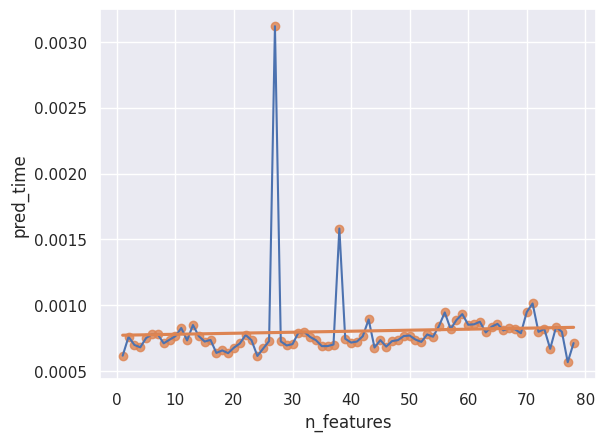

In [26]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['pred_time','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='pred_time')
    sns.regplot(data=data, x="n_features", y="pred_time", ci=None)  # ci=None removes confidence intervals

print_plot()

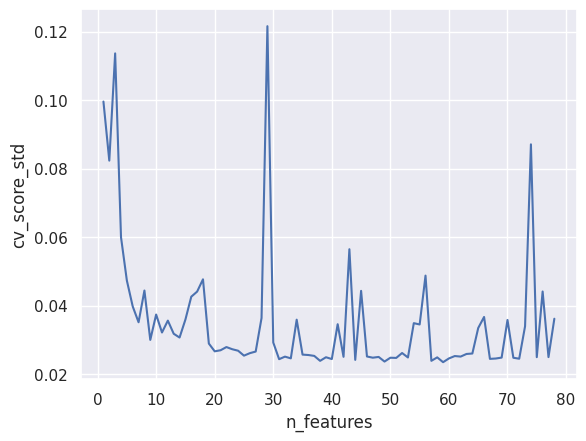

In [27]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['cv_score_std','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='cv_score_std')

print_plot()

In [28]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time', 'detected']].mean().sort_values(['attack_recall', 'attack_precision'], ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time,detected
n_features,,,,,,,,
1,0.551974,0.750000,0.444382,0.832914,0.099582,10.112308,0.000617,1.00
29,0.519763,0.750000,0.398620,0.908851,0.121578,8.821051,0.000695,0.75
38,0.561579,0.743062,0.455599,0.949635,0.023905,7.292583,0.001583,0.75
66,0.553821,0.742986,0.441474,0.945671,0.036711,9.354148,0.000809,0.75
8,0.635815,0.727203,0.564936,0.920842,0.044425,8.984650,0.000711,0.75
...,...,...,...,...,...,...,...,...
70,0.000000,0.000000,0.000000,0.946081,0.035836,9.306561,0.000948,0.00
71,0.000000,0.000000,0.000000,0.950066,0.024809,9.497737,0.001013,0.00
72,0.000000,0.000000,0.000000,0.951324,0.024528,13.637598,0.000798,0.00


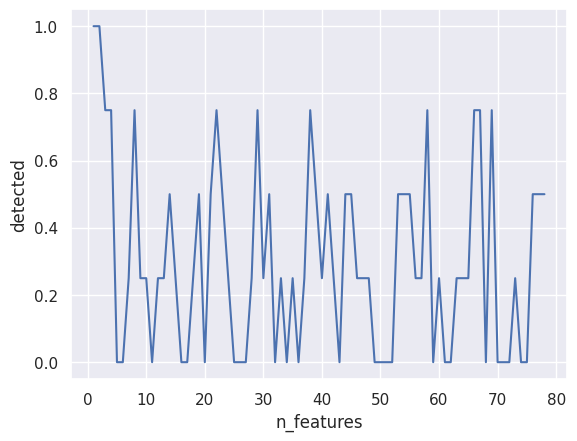

In [29]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['detected','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='detected')

print_plot()

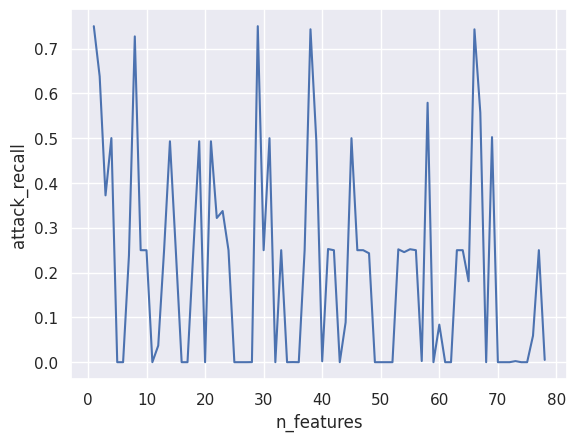

In [30]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_recall','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_recall')

print_plot()

In [31]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time']].mean().sort_values('attack_f1', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time
n_features,,,,,,,
8,0.635815,0.727203,0.564936,0.920842,0.044425,8.984650,0.000711
38,0.561579,0.743062,0.455599,0.949635,0.023905,7.292583,0.001583
66,0.553821,0.742986,0.441474,0.945671,0.036711,9.354148,0.000809
1,0.551974,0.750000,0.444382,0.832914,0.099582,10.112308,0.000617
29,0.519763,0.750000,0.398620,0.908851,0.121578,8.821051,0.000695
...,...,...,...,...,...,...,...
16,0.000000,0.000000,0.000000,0.931947,0.042625,9.178038,0.000736
49,0.000000,0.000000,0.000000,0.951213,0.023699,7.762286,0.000766
50,0.000000,0.000000,0.000000,0.950499,0.024815,7.749654,0.000770


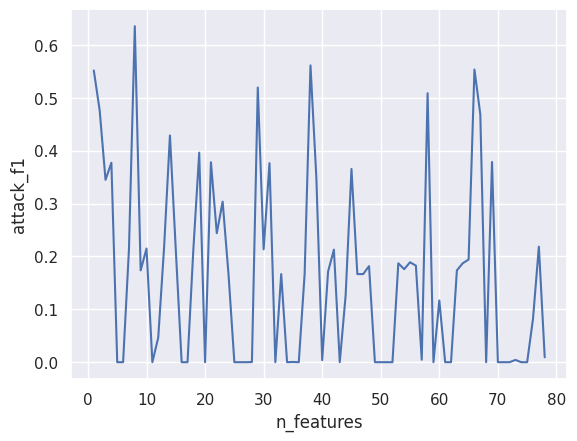

In [32]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_f1')

print_plot()

In [33]:
zero_day_feature_reduction_scores.query('n_features == 8')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
71,0.846522,0.972248,0.749589,0.918665,0.033140,8,XMRIGCC CryptoMiner,5.428372,0.000649,1
150,0.000000,0.000000,0.000000,0.965795,0.015797,8,Probing,6.280287,0.000609,0
229,0.832137,0.936566,0.748659,0.888226,0.092079,8,Bruteforce,12.217481,0.000801,1
308,0.864601,1.000000,0.761496,0.910684,0.036686,8,Bruteforce-XML,12.012460,0.000784,1
